# 常见的阿尔法因子

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from sklearn.preprocessing import scale
import talib

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1).round(1)

## 加载数据

In [5]:
data = pd.read_hdf('cn_data.h5', 'data/top50')
price_sample = pd.read_hdf('cn_data.h5', 'data/sample')

## TA-Lib：函数组

按组列出可用功能的数量

In [6]:
function_groups = ['重叠研究(Overlap Studies)',
                   '动量指标(Momentum Indicators)',
                   '成交量指标(Volume Indicators)',
                   '波动率指标(Volatility Indicators)',
                   '价格转换(Price Transform)',
                   '周期指标(Cycle Indicators)',
                   '模式识别(Pattern Recognition)',
                   '统计功能(Statistic Functions)',
                   '数学变换(Math Transform)',
                   '数学运算(Math Operators)']

In [7]:
talib_grps = talib.get_function_groups()

|功能组| # 指标   |
|:---|---|
|重叠研究(Overlap Studies)	| 17|
|动量指标(Momentum Indicators)	| 30|
|成交量指标(Volume Indicators)	| 3|
|波动率指标(Volatility Indicators)	| 3|
|价格转换(Price Transform)	| 4|
|周期指标(Cycle Indicators)	| 5|
|模式识别(Pattern Recognition)	| 61|
|数学运算(Math Operators)	| 11|
|数学变换(Math Transform)	| 15|
|统计功能(Statistic Functions)	| 9|

TA-Lib的[Python接口](http://mrjbq7.github.io/ta-lib/)的[文档](https://mrjbq7.github.io/ta-lib/doc_index.html)非常有限;您可以在[C源代码]的文档字符串中找到有关各种函数的最准确的信息（https://sourceforge.net/p/ta-lib/code/HEAD/tree/trunk/ta-lib/c /src/ta_func/)


## 不稳定时期

一些 TA-Lib 函数依赖于所有过去的数据，有时被称为具有记忆的函数。例如，指数移动平均线 (EMA) 在计算中递归地使用先前的 EMA。因此，给定的数据点将继续对所有后续值产生影响。相比之下，简单移动平均线 (SMA) 仅反映数据有限窗口中的值。

下图显示了三个 EMA，全部配置为 9 个周期。唯一的区别是它们在不同的时间点开始处理。请注意，它们最终会稳定并重叠。

https://ta-lib.org/d_api/ta_setunstableperiod.html

## 移动平均线

许多指标允许使用不同类型的移动平均线进行计算

|MA型|名称 |代码|
|:---|---:|:---:|
|SMA |简单移动平均线| 0|
|EMA |指数移动平均线| 1|
|WMA |加权移动平均线| 2|
|DEMA |双指数移动平均线| 3|
|TEMA  |三重指数移动平均线| 4|
|TRIMA   |三角移动平均线| 5|
|KAMA  |考夫曼自适应移动平均线| 6|
|MAMA | MESA 自适应移动平均线| 7|
|T3 |三重指数移动平均线| 8|

### 简单移动平均线 (SMA)


对于窗口长度为 $N$ 的价格系列 $P_t$，时间 $t$ 的简单移动平均线对窗口内的每个数据点进行相同的权重：
$$\text{SMA}(N)_t= \frac{P_{t-N+1}+P_{t-N+2}+P_{t-N+3}+P_{t}}{N}=\frac{1}{N}\sum_{i=1}^N P_{t-N+i}$$

In [11]:
df = price_sample.loc['2020': '2023', ['close']]

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 841 entries, 2020-01-02 to 2023-06-21
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   841 non-null    float64
dtypes: float64(1)
memory usage: 13.1 KB


In [13]:
for t in [5, 21, 63]:
    df[f'SMA_{t}'] = talib.SMA(df.close,
                               timeperiod=t)

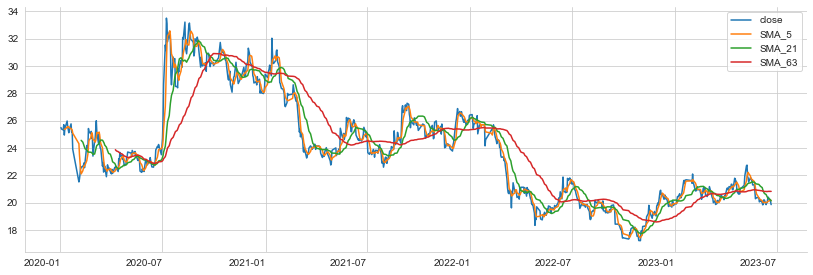

In [14]:
ax = df.plot(figsize=(14, 5), rot=0)
sns.despine()
ax.set_xlabel('');

### 指数移动平均线 (EMA)

对于窗口长度为 $N$ 的价格系列 $P_t$，时间 $t$ 的指数移动平均线 $EMA_t$ 被递归地定义为当前价格和最近的前一个 $EMA_{t-1}$ 的加权平均值，其中权重 $\alpha$ 和 $1-\alpha$ 定义如下：
$$\begin{align*}
\text{EMA}(N)_t&= \alpha P_t  + (1-\alpha)\text{EMA}(N)_{t-1} \\
\alpha&=\frac{2}{N+1}\\
\end{align*}$$

In [15]:
df = price_sample.loc['2022', ['close']]

In [16]:
for t in [5, 21, 63]:
    df[f'EMA_{t}'] = talib.EMA(df.close,
                               timeperiod=t)

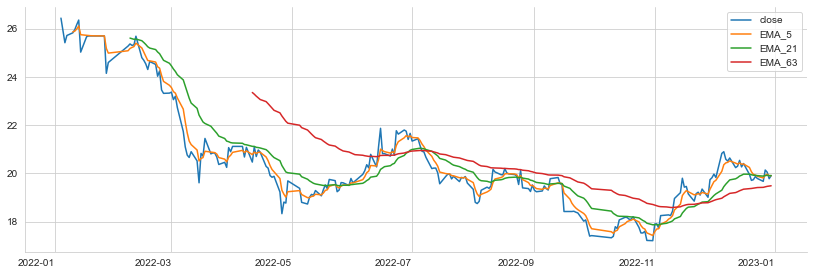

In [17]:
ax = df.plot(figsize=(14, 5), rot=0)
sns.despine()
ax.set_xlabel('');

### 加权移动平均线 (WMA)

对于窗口长度为 $N$ 的价格系列 $P_t$，计算时间 $t$ 时的加权移动平均值，使每个数据点的权重对应于其在窗口内的索引：
$$\text{WMA}(N)_t= \frac{P_{t-N+1}+2P_{t-N+2}+3P_{t-N+3}+NP_{t}}{N(N+1)/2}$$

In [18]:
df = price_sample.loc['2022', ['close']]

In [19]:
for t in [5, 21, 63]:
    df[f'WMA_{t}'] = talib.WMA(df.close,
                               timeperiod=t)

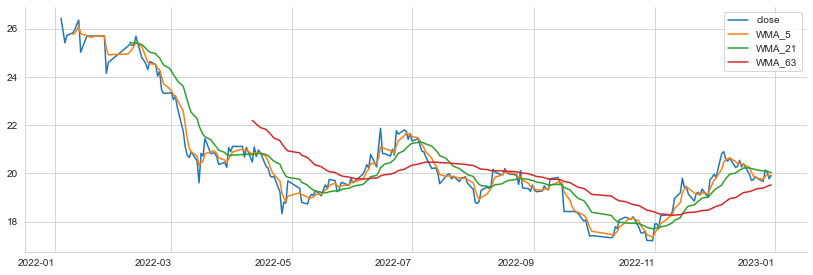

In [20]:
ax = df.plot(figsize=(14, 5), rot=0)
sns.despine()
ax.set_xlabel('');

### 双指数移动平均线 (DEMA)

价格系列 $P_t$ 在 $t$ 时间 $\text{DEMA}_t$ 的双指数移动平均线基于 EMA，但旨在更快地对价格变化做出反应。 It 计算为当前 EMA 的两倍与应用于当前 EMA 的 EMA 之间的差值，标记为 $\text{EMA}_2(N)_t$：

$$\text{DEMA}(N)_t=2\times\text{EMA}(N)_t-\text{EMA}_2(N)_t$$

由于计算使用 $\text{EMA}_2$，DEMA 需要 2 * N - 1 个样本才能开始生成值。


In [21]:
df = price_sample.loc['2022', ['close']]

In [22]:
for t in [5, 21, 63]:
    df[f'DEMA_{t}'] = talib.DEMA(df.close,
                                timeperiod=t)

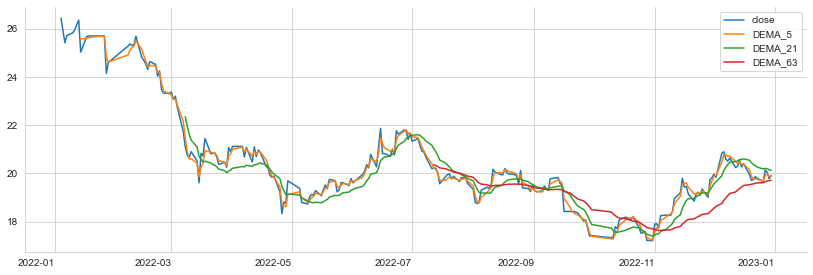

In [23]:
ax = df.plot(figsize=(14, 5), rot=0)
sns.despine()
ax.set_xlabel('');

### 三重指数移动平均线 (TEMA)

价格系列 $P_t$ 在 $t$、$\text{TEMA}_t$ 时的三重指数移动平均线基于 EMA，但旨在更快地对价格变化做出反应并指示短期价格方向。它的计算方式为当前 EMA 与应用于当前 EMA $\text{EMA}_2$ 的 EMA 之差的三倍之差，并添加 $\text{EMA}_2$ 的 EMA，标记为如 $\text{EMA}_3$:

$$\text{TEMA}(N)_t=3\times\left[\text{EMA}(N)_t-\text{EMA}_2(N)_t\right] + \text{EMA}_3(N)_t$$

由于计算使用 $\text{EMA}_3$，DEMA 需要 3 * N - 2 个样本才能开始生成值。

In [25]:
df = price_sample.loc['2022', ['close']]

In [26]:
for t in [5, 21, 63]:
    df[f'TEMA_{t}'] = talib.TEMA(df.close,
                                timeperiod=t)

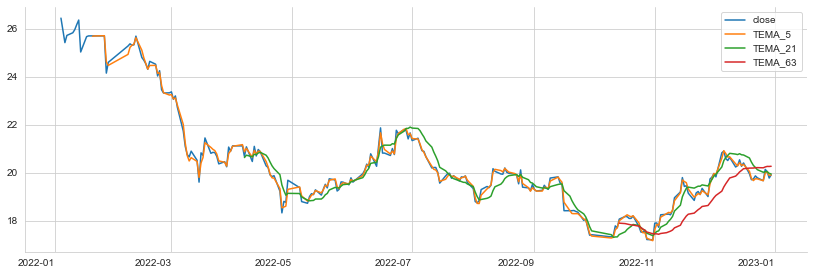

In [27]:
ax = df.plot(figsize=(14, 5), rot=0)
sns.despine()
ax.set_xlabel('');

### 三角移动平均线 (TRIMA)

时间 $t$ 的价格系列 $P_t$ 的窗口长度为 N 的三角移动平均线 (TRIMA)，$\text{TRIMA}(N)_t$ 是最后 N 个 $SMA(N)_t$ 的加权平均值价值观。换句话说，它将 SMA 应用于 SMA 值的时间序列：

$$\text{TRIMA}(N)_t=\frac{1}{N}\sum_{i=1}^N \text{SMA}(N)_{t-N+i}$$

由于计算将 SMA(N) 应用于 SMA(N)，因此 TRIMA 需要 2 * N - 1 个样本才能开始生成值。

In [28]:
df = price_sample.loc['2022', ['close']]

In [29]:
for t in [5, 21, 63]:
    df[f'TRIMA_{t}'] = talib.TRIMA(df.close,
                                timeperiod=t)

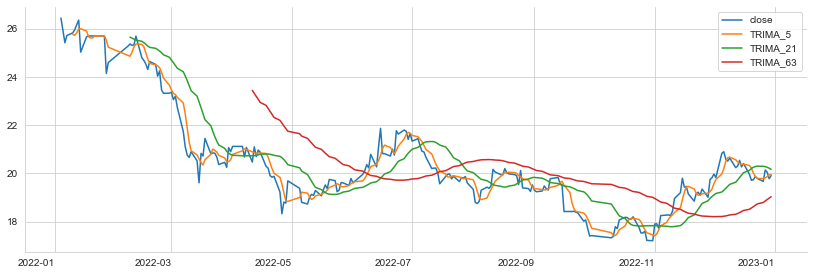

In [30]:
ax = df.plot(figsize=(14, 5), rot=0)
sns.despine()
ax.set_xlabel('');

### 考夫曼自适应移动平均线 (KAMA)

考夫曼自适应移动平均线的计算旨在考虑市场波动性的变化。有关稍微复杂的计算的详细信息，请参阅[此处](https://www.technicalindicators.net/indicators-technical-analysis/152-kama-kaufman-adaptive-moving-average)。

In [32]:
df = price_sample.loc['2022', ['close']]

In [33]:
for t in [5, 21, 63]:
    df[f'KAMA_{t}'] = talib.KAMA(df.close,
                                timeperiod=t)

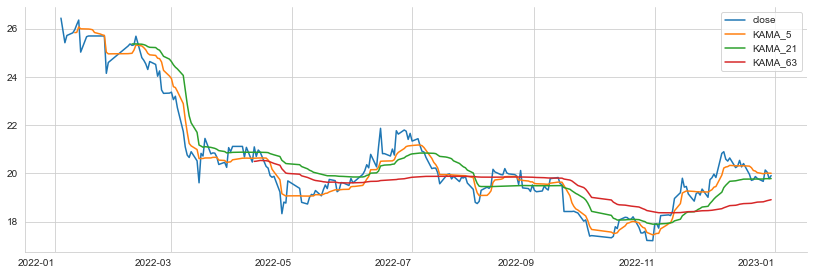

In [34]:
ax = df.plot(figsize=(14, 5), rot=0)
sns.despine()
ax.set_xlabel('');

### MESA 自适应移动平均线 (MAMA)

MESA 自适应移动平均线 (MAMA) 是一种指数移动平均线，它根据希尔伯特变换判别器测量的相位变化率来适应价格变动（见下文）。除了价格系列之外，MAMA 还接受两个附加参数“fastlimit”和“slowlimit”，它们控制计算 MAMA 时应应用于 EMA 的最大和最小 alpha 值。

In [35]:
df = price_sample.loc['2022', ['close']]

In [36]:
len(talib.MAMA(df.close,
                         fastlimit=.5,
                         slowlimit=.05))

2

In [37]:
mama, fama = talib.MAMA(df.close,
                        fastlimit=.5,
                        slowlimit=.05)
df['mama'] = mama
df['fama'] = fama

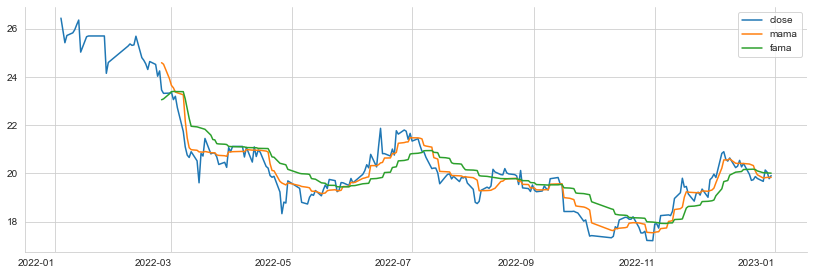

In [38]:
ax = df.plot(figsize=(14, 5), rot=0)
sns.despine()
ax.set_xlabel('');

### 比较

In [39]:
df = price_sample.loc['2022', ['close']]
t = 21

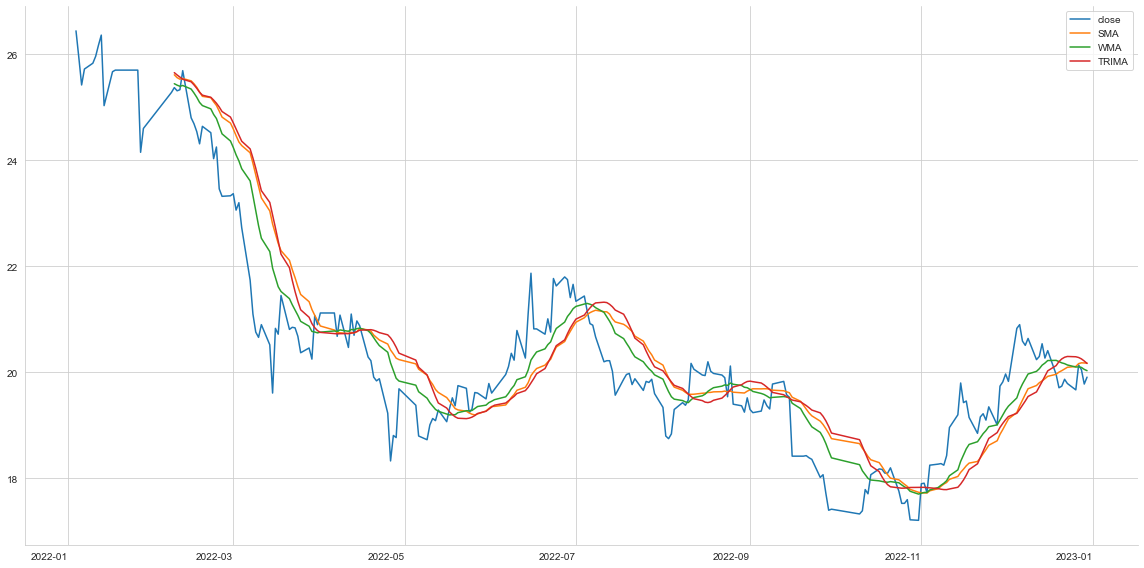

In [40]:
df['SMA'] = talib.SMA(df.close, timeperiod=t)
df['WMA'] = talib.WMA(df.close, timeperiod=t)
df['TRIMA'] = talib.TRIMA(df.close, timeperiod=t)

ax = df[['close', 'SMA', 'WMA', 'TRIMA']].plot(figsize=(16, 8), rot=0)

sns.despine()
ax.set_xlabel('')
plt.tight_layout();

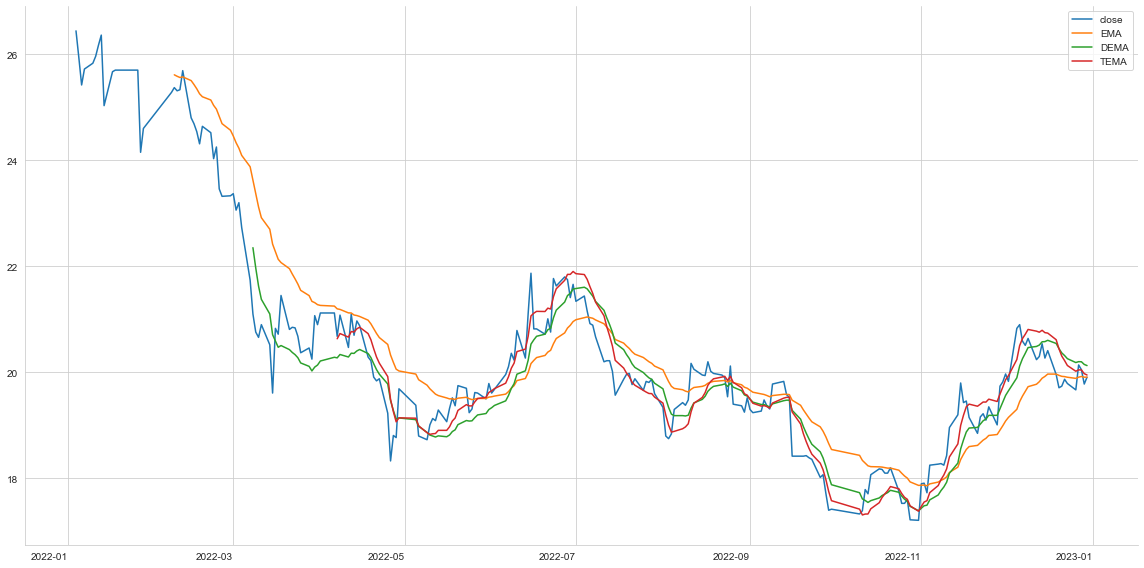

In [41]:
df['EMA'] = talib.EMA(df.close, timeperiod=t)
df['DEMA'] = talib.DEMA(df.close, timeperiod=t)
df['TEMA'] = talib.TEMA(df.close, timeperiod=t)

ax = df[['close', 'EMA', 'DEMA', 'TEMA']].plot(figsize=(16, 8), rot=0)

ax.set_xlabel('')
sns.despine()
plt.tight_layout();

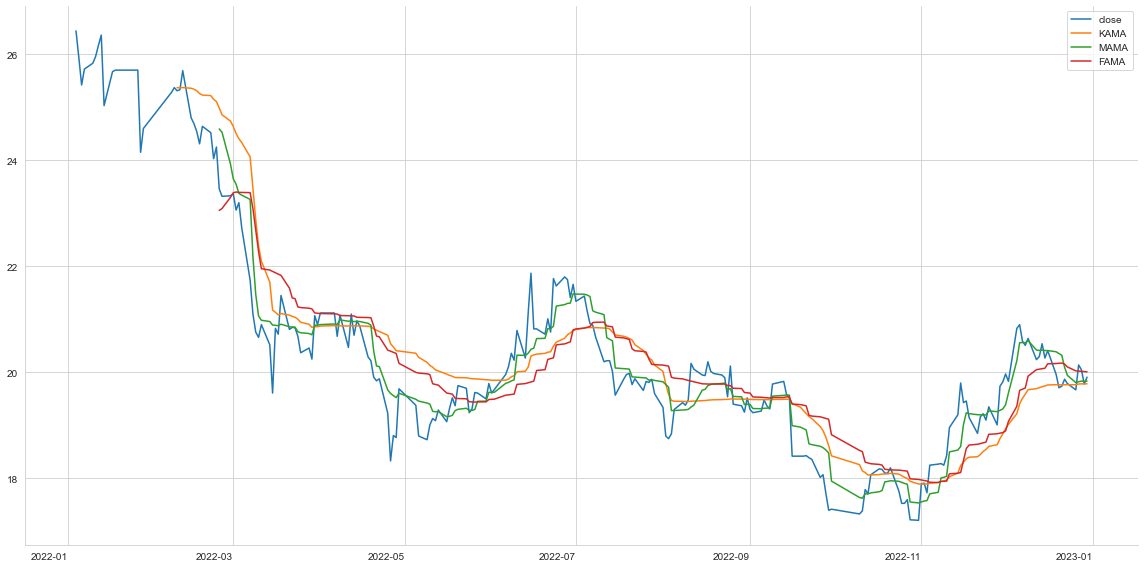

In [42]:
df['KAMA'] = talib.KAMA(df.close, timeperiod=t)
mama, fama = talib.MAMA(df.close,
                        fastlimit=.5,
                        slowlimit=.05)
df['MAMA'] = mama
df['FAMA'] = fama
ax = df[['close', 'KAMA', 'MAMA', 'FAMA']].plot(figsize=(16, 8), rot=0)

ax.set_xlabel('')
sns.despine()
plt.tight_layout();

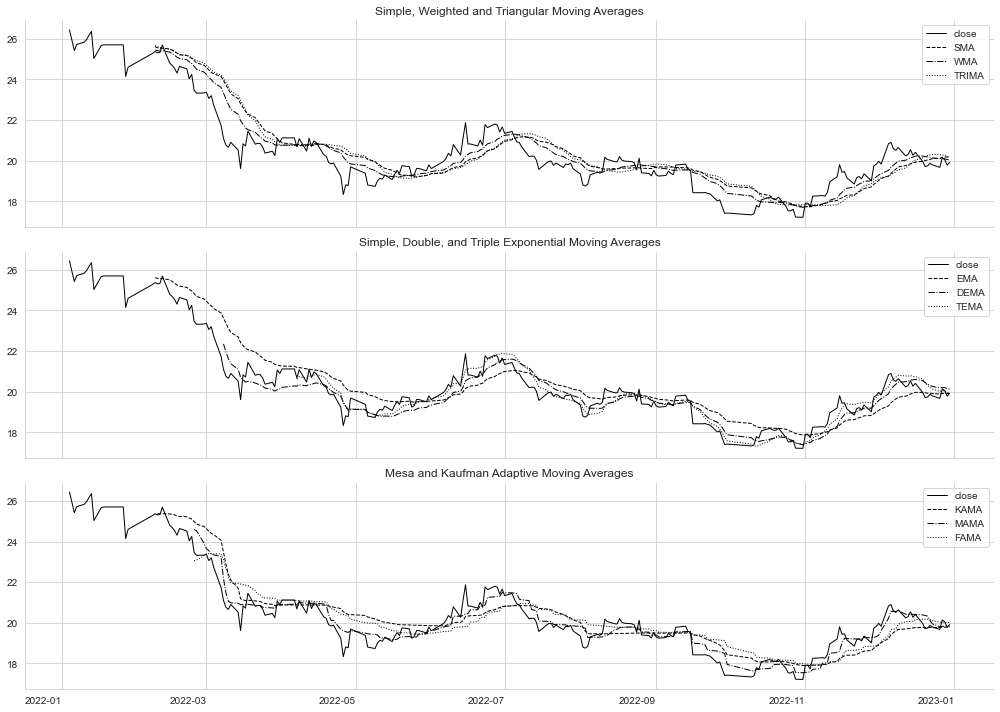

In [43]:
fig, axes = plt.subplots(nrows=3, figsize=(14, 10), sharex=True, sharey=True)


df[['close', 'SMA', 'WMA', 'TRIMA']].plot(rot=0,
                                          ax=axes[0],
                                          title='Simple, Weighted and Triangular Moving Averages',
                                          lw=1, style=['-', '--', '-.', ':'], c='k')
df[['close', 'EMA', 'DEMA', 'TEMA']].plot(rot=0, ax=axes[1],
                                          title='Simple, Double, and Triple Exponential Moving Averages',
                                          lw=1, style=['-', '--', '-.', ':'], c='k')

df[['close', 'KAMA', 'MAMA', 'FAMA']].plot(rot=0, ax=axes[2],
                                          title='Mesa and Kaufman Adaptive Moving Averages',
                                          lw=1, style=['-', '--', '-.', ':'], c='k')
axes[2].set_xlabel('')
sns.despine()
plt.tight_layout();

## 重叠研究

|Function  |Name  |
|:---|:---|
|BBANDS               |布林线|
|HT_TRENDLINE         |希尔伯特变换 - 瞬时趋势线|
|MAVP                 |可变周期移动平均线|
|MA                   |移动平均线|
|MIDPOINT             |期间中点|
|MIDPRICE             |一段时间内的中点价格|
|SAR                  |抛物线转向指标|
|SAREXT               |抛物线 SAR - 扩展|

### 布林线

In [44]:
s = talib.BBANDS(df.close,   # Number of periods (2 to 100000)
                 timeperiod=20,
                 nbdevup=2,    # Deviation multiplier for lower band
                 nbdevdn=2,    # Deviation multiplier for upper band
                 matype=1      # default: SMA
                 )

In [45]:
bb_bands = ['upper', 'middle', 'lower']

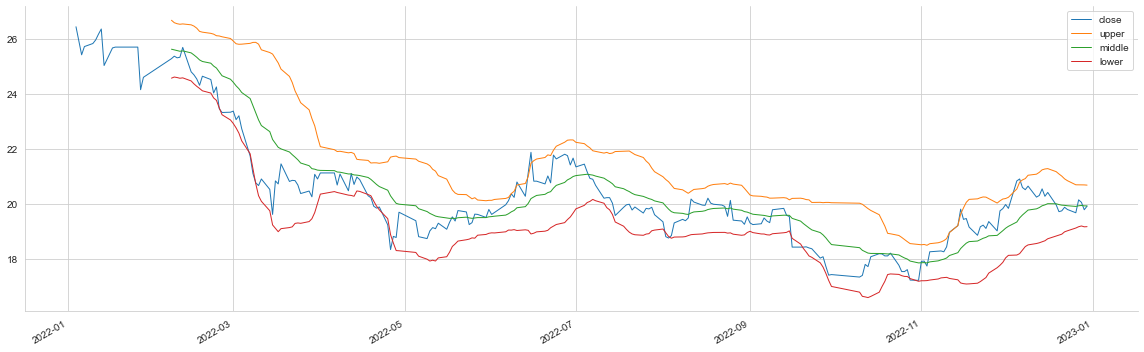

In [46]:
df = price_sample.loc['2022', ['close']]
df = df.assign(**dict(zip(bb_bands, s)))
ax = df.loc[:, ['close'] + bb_bands].plot(figsize=(16, 5), lw=1)

ax.set_xlabel('')
sns.despine()
plt.tight_layout();

#### 标准化挤压和均值回归指标

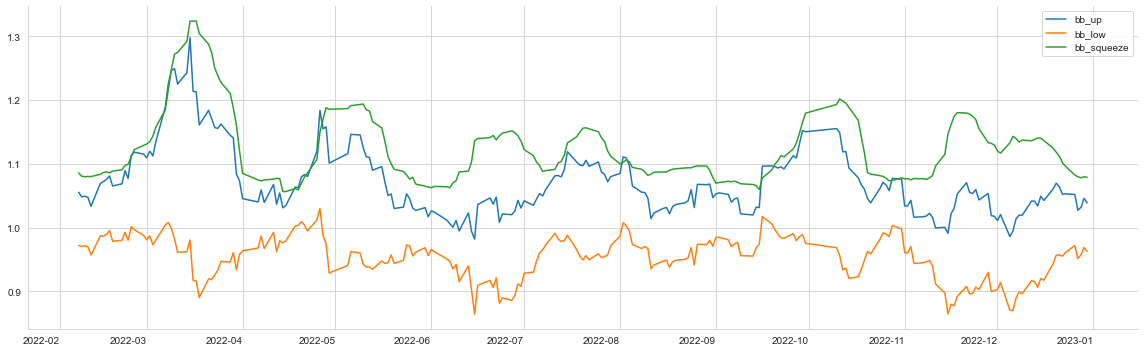

In [47]:
fig, ax = plt.subplots(figsize=(16,5))
df.upper.div(df.close).plot(ax=ax, label='bb_up')
df.lower.div(df.close).plot(ax=ax, label='bb_low')
df.upper.div(df.lower).plot(ax=ax, label='bb_squeeze', rot=0)

plt.legend()
ax.set_xlabel('')
sns.despine()
plt.tight_layout();

In [48]:
def compute_bb_indicators(close, timeperiod=20, matype=0):
    high, mid, low = talib.BBANDS(close, 
                                  timeperiod=20,
                                  matype=matype)
    bb_up = high / close -1
    bb_low = low / close -1
    squeeze = (high - low) / close
    return pd.DataFrame({'BB_UP': bb_up, 
                         'BB_LOW': bb_low, 
                         'BB_SQUEEZE': squeeze}, 
                        index=close.index)

In [49]:
data = (data.join(data
                  .groupby(level='code')
                  .close
                  .apply(compute_bb_indicators)))

In [53]:
data.tail()

open    high     low   close      volume code_name  \
code      date                                                               
sz.300274 2023-06-14  104.88  106.28  102.50  103.17  18273918.0      阳光电源   
          2023-06-15  103.38  112.00  102.12  110.77  38679861.0      阳光电源   
          2023-06-16  111.30  114.98  110.00  114.09  31711869.0      阳光电源   
          2023-06-19  113.00  115.87  112.50  113.95  16183960.0      阳光电源   
          2023-06-20  113.60  115.72  112.64  113.56  14168712.0      阳光电源   

                            mktcap industry  sector    ret_01  ...    ret_10  \
code      date                                                 ...             
sz.300274 2023-06-14  1.277860e+09     电气设备      11 -0.012822  ... -0.063283   
          2023-06-15  1.277860e+09     电气设备      11  0.073665  ...  0.029078   
          2023-06-16  1.277860e+09     电气设备      11  0.029972  ...  0.056780   
          2023-06-19  1.277860e+09     电气设备      11 -0.001227  ...  0.094831   
          2023-06-20  1.277860e+09     电气设备      11 -0.003423  ...  0.082039   

                        ret_21    ret_42    ret_63   ret_126   ret_252  \
code      date                                                           
sz.300274 2023-06-14 -0.114573  0.033871 -0.073961 -0.021250  0.213765   
          2023-06-15 -0.053005  0.107257  0.047768  0.043720  0.202714   
          2023-06-16  0.002989  0.118091  0.087400  0.064074  0.199811   
          2023-06-19 -0.006366  0.109758  0.157676  0.066948  0.226588   
          2023-06-20 -0.002109  0.033491  0.180948  0.082348  0.237576   

                       ret_fwd     BB_UP    BB_LOW  BB_SQUEEZE  
code      date                                                  
sz.300274 2023-06-14  0.073665  0.160182 -0.042754    0.202936  
          2023-06-15  0.029972  0.077625 -0.108166    0.185791  
          2023-06-16 -0.001227  0.045471 -0.133840    0.179312  
          2023-06-19 -0.003423  0.046946 -0.132834    0.179780  
          2023-06-20 -0.003610  0.049523 -0.129533    0.179056  

[5 rows x 24 columns]

#### 可视化分布

In [50]:
bb_indicators = ['BB_UP', 'BB_LOW', 'BB_SQUEEZE']

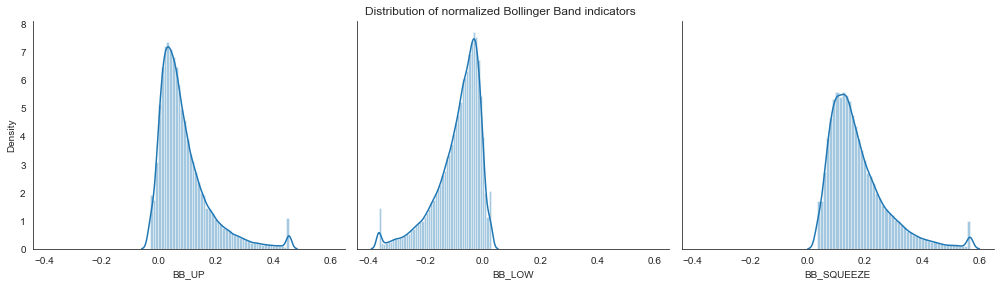

In [51]:
q = .01
with sns.axes_style('white'):
    fig, axes = plt.subplots(ncols=3, figsize=(14, 4), sharey=True, sharex=True)
    df_ = data[bb_indicators]
    df_ = df_.clip(df_.quantile(q), 
                   df_.quantile(1-q), axis=1)
    for i, indicator in enumerate(bb_indicators):
        sns.distplot(df_[indicator], ax=axes[i])
    fig.suptitle('Distribution of normalized Bollinger Band indicators', fontsize=12)

    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.93);

#### 绘制离群价格序列

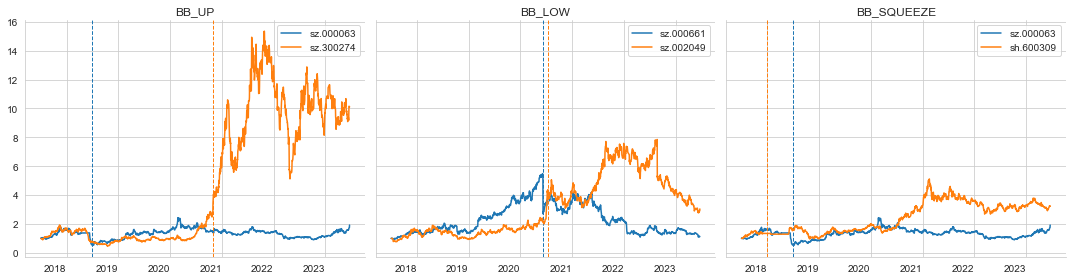

In [55]:
ncols = len(bb_indicators)
fig, axes = plt.subplots(ncols=ncols, figsize=(5*ncols, 4), sharey=True)
for i, indicator in enumerate(bb_indicators):
    ticker, date = data[indicator].nlargest(1).index[0]
    p = data.loc[idx[ticker, :], :].close.reset_index('code', drop=True)
    p = p.div(p.dropna().iloc[0])
    p.plot(ax=axes[i], label=ticker, rot=0)
    c = axes[i].get_lines()[-1].get_color()
    axes[i].axvline(date, ls='--', c=c, lw=1)
    ticker, date = data[indicator].nsmallest(1).index[0]
    p = data.loc[idx[ticker, :], :].close.reset_index('code', drop=True)
    p = p.div(p.dropna().iloc[0])
    p.plot(ax=axes[i], label=ticker, rot=0)    
    c = axes[i].get_lines()[-1].get_color()
    axes[i].axvline(date, ls='--', c=c, lw=1)
    axes[i].set_title(indicator.upper())
    axes[i].legend()
    axes[i].set_xlabel('')
sns.despine()
fig.tight_layout();

### 希尔伯特变换 - 瞬时趋势线

希尔伯特变换生成去趋势实值信号（如价格序列）的同相和正交分量，以分析瞬时相位和幅度的变化。

HTTrendline 返回由希尔伯特变换生成的分析信号的主循环被移除后的价格序列值。主周期可以被认为是价格序列正弦函数“最有可能”的周期（在 10 到 40 的范围内）。有关计算的更多详细信息，请参阅[此处](http://www2.wealth-lab.com/WL5Wiki/HTTrendLine.ashx)。


In [56]:
df = price_sample.loc['2022', ['close']]
df['HT_TRENDLINE'] = talib.HT_TRENDLINE(df.close)

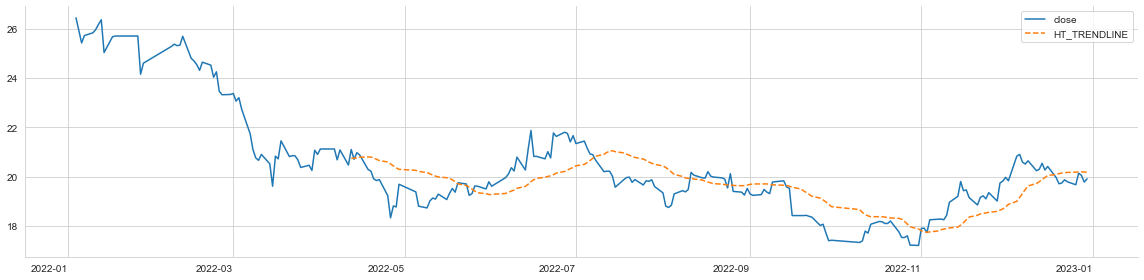

In [57]:
ax = df.plot(figsize=(16, 4), style=['-', '--'], rot=0)

ax.set_xlabel('')
sns.despine()
plt.tight_layout();

#### 计算基于希尔伯特的归一化指标

In [58]:
data['HT'] = (data
              .groupby(level='code', group_keys=False)
              .close
              .apply(talib.HT_TRENDLINE)
              .div(data.close).sub(1))

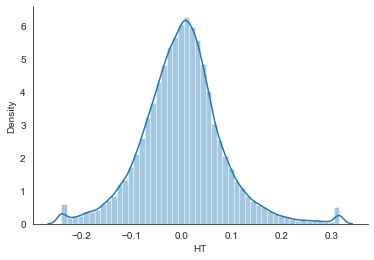

In [59]:
q=0.005
with sns.axes_style('white'):
    sns.distplot(data.HT.clip(data.HT.quantile(q), data.HT.quantile(1-q)))
    sns.despine();

### 抛物线转向指标

抛物线转向指标旨在识别趋势逆转。它是一种趋势跟踪（滞后）指标，可用于设置追踪止损或确定入场点或出场点。它通常在价格图表中表示为价格柱附近的一组点。一般来说，当这些点位于价格上方时，则表示下降趋势；如果这些点位于价格下方，则表示上升趋势。点方向的变化可以解释为交易信号。然而，该指标在平坦或区间波动的市场中并不那么可靠。其计算如下：

$$\text{SAR}_t=\text{SAR}_{t-1} + \alpha (\text{EP}-\text{SAR}_{t-1})$$

EP（极值点）是每个趋势期间保存的记录，代表价格在当前上升趋势期间达到的最高值，或在下降趋势期间达到的最低值。在每个周期内，如果观察到新的最大值（或最小值），则 EP 会使用该值进行更新。

α 值表示加速因子，通常初始设置为 0.02。每次录制新 EP 时，该因子都会增加 α。然后，汇率将加快至 SAR 向价格收敛的点。为了防止它变得太大，加速因子的最大值通常设置为0.20。

有关更多详细信息，请参阅[维基百科](https://en.wikipedia.org/wiki/Parabolic_SAR)；还有一个[扩展SAR](http://www.tadoc.org/indicator/SAR.htm)。


In [60]:
df = price_sample.loc['2022', ['close', 'high', 'low']]
df['SAR'] = talib.SAR(df.high, df.low, 
                      acceleration=0.02, # common value
                      maximum=0.2)       

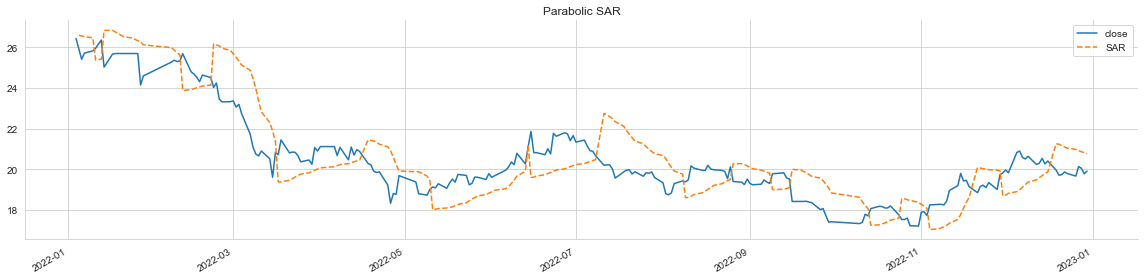

In [61]:
ax = df[['close', 'SAR']].plot(figsize=(16, 4), style=['-', '--'], title='Parabolic SAR')
ax.set_xlabel('')
sns.despine()
plt.tight_layout();

#### 归一化 SAR 指标

In [62]:
def compute_sar_indicator(x, acceleration=.02, maximum=0.2):
    sar = talib.SAR(x.high, 
                    x.low,
                    acceleration=acceleration,
                    maximum=maximum)
    return sar/x.close - 1

In [64]:
data['SAR'] = (data.groupby(level='code', group_keys=False)
                  .apply(compute_sar_indicator))

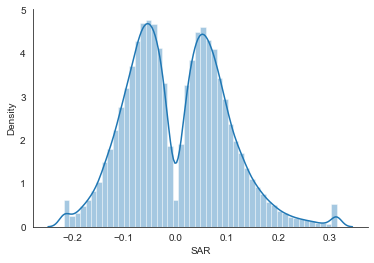

In [65]:
q=0.005
with sns.axes_style('white'):
    sns.distplot(data.SAR.clip(data.SAR.quantile(q), data.SAR.quantile(1-q)))
    sns.despine()

## 动量指标

|Function|             Name|
|:---|:---|
|PLUS_DM|              正方向运动|
|MINUS_DM|             负方向运动|
|PLUS_DI|              正方向指示器|
|MINUS_DI|             负方向指示器|
|DX|                   定向运动指数|
|ADX|                  平均定向运动指数|
|ADXR|                 平均方向运动指数评级|
|APO|                  绝对价格震荡指标|
|PPO|                  百分比价格摆动指标|
|AROON|                Aroon|
|AROONOSC|             Aroon 振荡器|
|BOP|                  能量均衡|
|CCI|                  商品通道指数|
|CMO|                  钱德动量振荡器|
|MACD|                 移动平均线收敛/发散|
|MACDEXT|              MACD与可控MA类型|
|MACDFIX|              移动平均线收敛/发散修复 12/26|
|MFI|                  资金流量指数|
|MOM|                  势头|
|RSI|                  相对强弱指数|
|STOCH|                随机|
|STOCHF|               快速随机|
|STOCHRSI|             随机相对强弱指数|
|TRIX|                 三重平滑 EMA 的 1 日变化率 (ROC)|
|ULTOSC|               终极振荡器|
|WILLR|                Williams' %R|

### 平均方向运动指数 (ADX)

ADX 结合了另外两个指标，即正向指标和方向指标（PLUS_DI 和 MINUS_DI），而这两个指标又建立在正向运动和方向运动（PLUS_DM 和 MINUS_DM）的基础上。有关更多详细信息，请参阅 [Wikipdia](https://en.wikipedia.org/wiki/Average_direction_movement_index) 和 [Investopedia](https://www.investopedia.com/articles/trading/07/adx-trend-indicator.asp ）。

#### 正/负方向运动 (PLUS_DM/MINUS_DM)

对于具有每日高点 $P^H_t$ 和每日低点 $P^L_t$ 的价格系列 $P_t$，定向运动跟踪时间段 T 内价格运动的绝对大小，如下所示：

$$\begin{align*}
\text{Up}_t & =P^H_t-P^H_{t-T} \\
\text{Down}_t & = P^L_{t-T} - P^L_t\\
\text{PLUS_DM}_t & = \\
\begin{cases}
\text{Up}_t & \text{if Up}_t > \text{Down}_t \text{and Up}_t > 0 \\
0 & \text{otherwise}
\end{cases} \\
\text{MINUS_DM}_t & = 
\begin{cases}
\text{Down}_t & \text{if Down}_t > \text{Up}_t \text{and Down}_t < 0 \\
0 & \text{otherwise}
\end{cases}
\end{align*}$$

In [66]:
df = price_sample.loc['2020': '2023', ['high', 'low', 'close']]

In [67]:
df['PLUS_DM'] = talib.PLUS_DM(df.high, df.low, timeperiod=10)
df['MINUS_DM'] = talib.MINUS_DM(df.high, df.low, timeperiod=10)

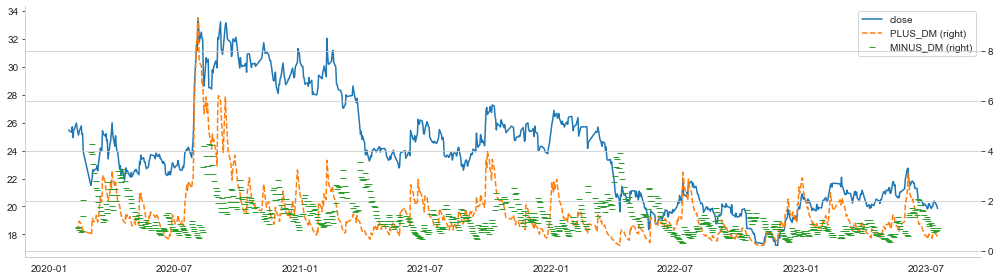

In [68]:
ax = df[['close', 'PLUS_DM', 'MINUS_DM']].plot(figsize=(14, 4),
                                               secondary_y=[
                                                   'PLUS_DM', 'MINUS_DM'],
                                               style=['-', '--', '_'],
                                              rot=0)
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

#### 加/减方向索引 (PLUS_DI/MINUS_DI)

“PLUS_DI”和“MINUS_DI”分别是“PLUS_DM”和“MINUS_DM”的简单移动平均值，分别除以平均真实波幅（“ATR”，见下文）。

平滑移动平均值是在选定的周期数上计算的，平均真实波动幅度是真实波动幅度的平滑平均值。

In [69]:
df = price_sample.loc['2020': '2023', ['high', 'low', 'close']]

In [70]:
df['PLUS_DI'] = talib.PLUS_DI(df.high, df.low, df.close, timeperiod=14)
df['MINUS_DI'] = talib.MINUS_DI(df.high, df.low, df.close, timeperiod=14)

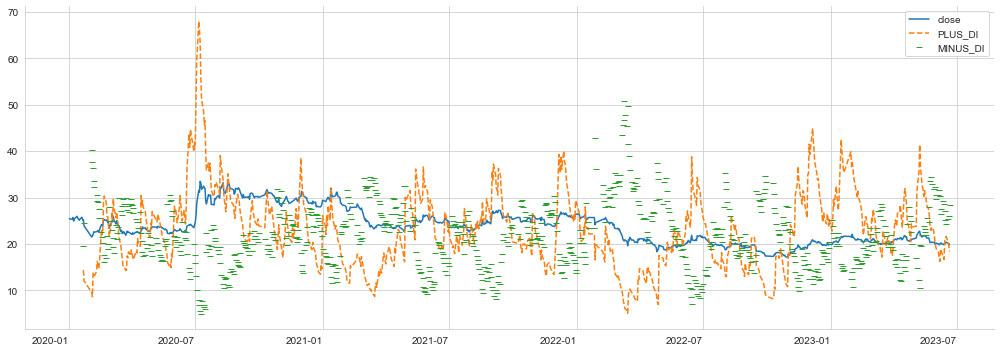

In [71]:
ax = df[['close', 'PLUS_DI', 'MINUS_DI']].plot(figsize=(14, 5), style=['-', '--', '_'], rot=0)

ax.set_xlabel('')
sns.despine()
plt.tight_layout();

#### 平均定向运动指数 (ADX)

ADX 是 PLUS_DI 和 MINUS_DI 之差的绝对值除以它们之和的（简单）移动平均值：

$$
\text{ADX}=100\times\text{SMA}(N)_t\left|\frac{\text{PLUS_DI}_t-\text{MINUS_DI}_t}{\text{PLUS_DI}_t+\text{MINUS_DI}_t}\right|
$$

|ADX 值|	趋势强度|
|:---|:---|
|0-25 |	趋势缺失或疲弱|
|25-50 |	强劲趋势|
|50-75 |	非常强劲的趋势|
|75-100 |	极其强劲的趋势|

In [72]:
df = price_sample.loc[:, ['high', 'low', 'close']]

In [73]:
df['ADX'] = talib.ADX(df.high, 
                      df.low, 
                      df.close, 
                      timeperiod=14)

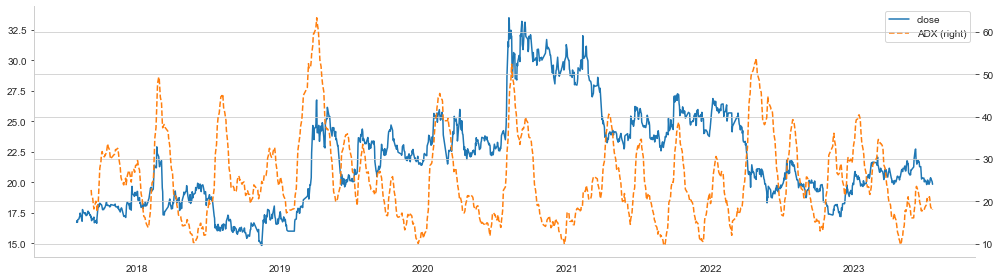

In [74]:
ax = df[['close', 'ADX']].plot(figsize=(14, 4), secondary_y='ADX', style=['-', '--'], rot=0)
ax.set_xlabel('')
sns.despine()
plt.tight_layout();

In [75]:
def compute_adx(x, timeperiod=14):
    return talib.ADX(x.high, 
                    x.low,
                    x.close,
                    timeperiod=timeperiod)

In [76]:
data['ADX'] = (data.groupby(level='code', group_keys=False)
                  .apply(compute_adx))

#### 可视化分布

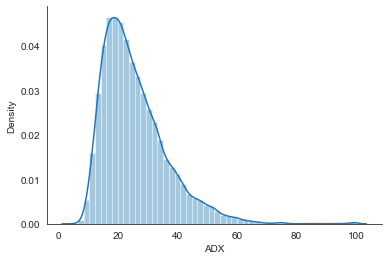

In [77]:
with sns.axes_style("white"):
    sns.distplot(data.ADX)
    sns.despine();

#### 平均方向运动指数评级

平均当前 ADX 和 ADX T 周期之前的值。

In [78]:
df = price_sample.loc[:, ['high', 'low', 'close']]

In [79]:
df['ADXR'] = talib.ADXR(df.high,
                        df.low,
                        df.close,
                        timeperiod=14)

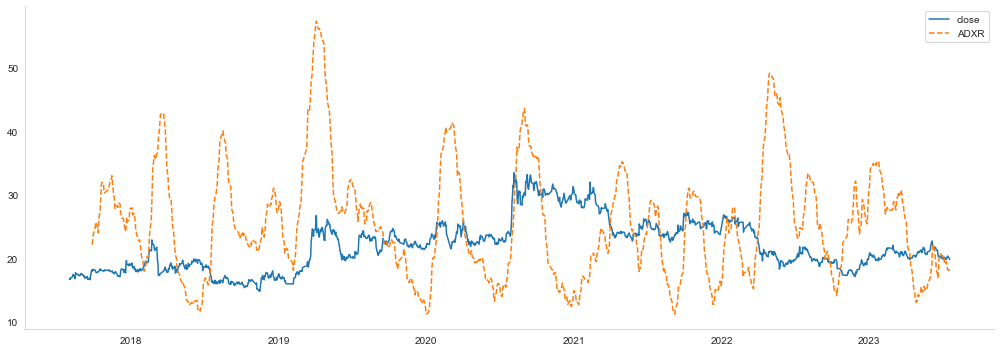

In [80]:
ax = df[['close', 'ADXR']].plot(figsize=(14, 5),
                                secondary_y='ADX',
                                style=['-', '--'], rot=0)
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

In [81]:
def compute_adxr(x, timeperiod=14):
    return talib.ADXR(x.high, 
                    x.low,
                    x.close,
                    timeperiod=timeperiod)

In [83]:
data['ADXR'] = (data.groupby(level='code', group_keys=False)
                .apply(compute_adxr))

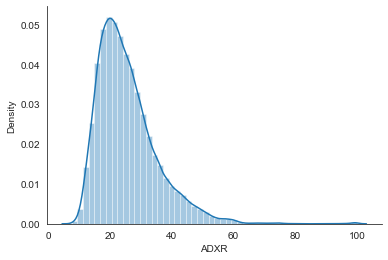

In [84]:
with sns.axes_style('white'):
    sns.distplot(data.ADXR)
    sns.despine();

### 绝对价格震荡指标 (APO)

绝对价格振荡指标 (APO) 计算为价格序列的两个指数移动平均线 (EMA) 之间的差值，以绝对值表示。 EMA 窗口通常分别包含 26 个和 12 个数据点。

In [85]:
df = price_sample.loc[:, ['close']]

In [86]:
df['APO'] = talib.APO(df.close,
                      fastperiod=12,
                      slowperiod=26,
                      matype=0)

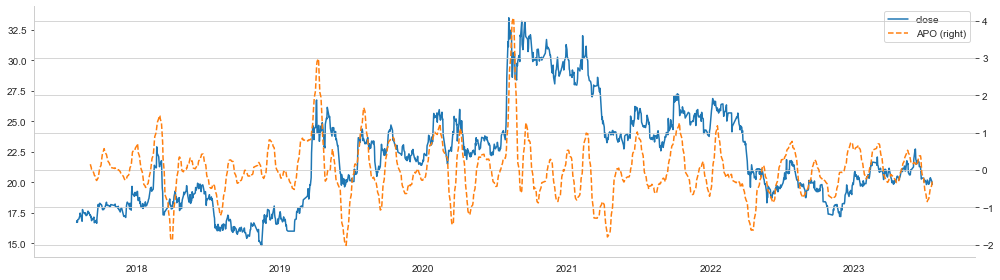

In [87]:
ax = df.plot(figsize=(14,4), secondary_y='APO', rot=0, style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout();

### 百分比价格摆动指标 (PPO)

百分比价格振荡指标 (APO) 计算为价格系列的两个指数移动平均线 (EMA) 之间的差值，以百分比值表示，因此可以在不同资产之间进行比较。 EMA 窗口通常分别包含 26 个和 12 个数据点。

In [88]:
df = price_sample.loc[:, ['close']]

In [89]:
df['PPO'] = talib.PPO(df.close,
                      fastperiod=12,
                      slowperiod=26,
                      matype=0)

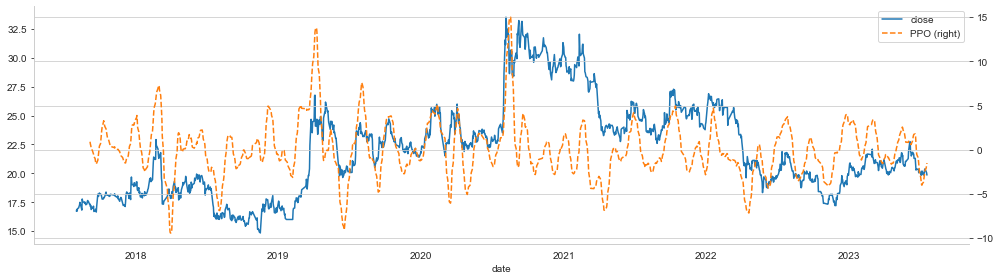

In [90]:
ax = df.plot(figsize=(14,4), secondary_y=['APO', 'PPO'], rot=0,  style=['-', '--'])

ax.set_xlabel('')
sns.despine()
plt.tight_layout();

In [91]:
data['PPO'] = (data.groupby(level='code')
               .close
               .apply(talib.PPO, 
                      fastperiod=12, 
                      slowperiod=26, 
                      matype=1))

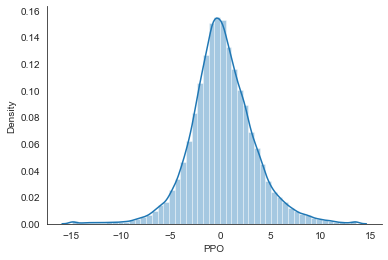

In [92]:
q = 0.001
with sns.axes_style("white"):
    sns.distplot(data.PPO.clip(lower=data.PPO.quantile(q),
                               upper=data.PPO.quantile(1-q)))
    sns.despine()

### Aroon 振荡器

#### Aroon 上/下指标

该指标衡量一段时间内高点之间的时间和低点之间的时间。它按如下方式计算 AROON_UP 和 AROON_DWN 指标：

$$
\begin{align*}
\text{AROON_UP}&=\frac{T-\text{Periods since T period High}}{T}\times 100\\
\text{AROON_DWN}&=\frac{T-\text{Periods since T period Low}}{T}\times 100
\end{align*}
$$

In [149]:
df = price_sample.loc['2022', ['high', 'low', 'close']]

In [150]:
aroonup, aroondwn = talib.AROON(high=df.high,
                                low=df.low,
                                timeperiod=14)
df['AROON_UP'] = aroonup
df['AROON_DWN'] = aroondwn

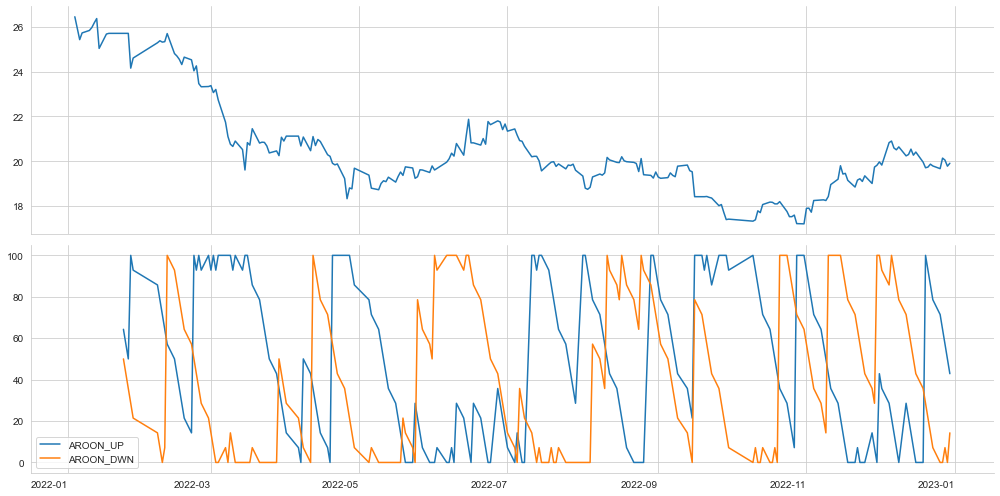

In [151]:
fig, axes = plt.subplots(nrows=2, figsize=(14, 7), sharex=True)
df.close.plot(ax=axes[0], rot=0)
df[['AROON_UP', 'AROON_DWN']].plot(ax=axes[1], rot=0)

axes[1].set_xlabel('')
sns.despine()
plt.tight_layout();

#### Aroon 振荡器

Aroon振荡器有Aroon上升指标和Aroon下降指标之间的差异。

In [152]:
df = price_sample.loc['2022', ['high', 'low', 'close']]

In [153]:
df['AROONOSC'] = talib.AROONOSC(high=df.high,
                                low=df.low,
                                timeperiod=14)

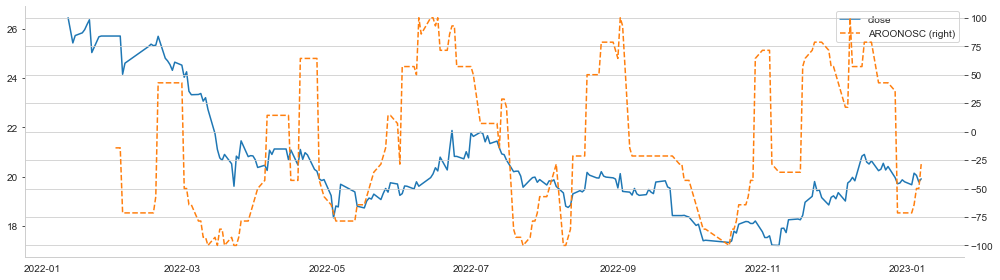

In [154]:
ax = df[['close', 'AROONOSC']].plot(figsize=(14,4), rot=0, style=['-', '--'], secondary_y='AROONOSC')
ax.set_xlabel('')
sns.despine()
plt.tight_layout();

In [155]:
data['AARONOSC'] = (data.groupby('code',
                                 group_keys=False)
                    .apply(lambda x: talib.AROONOSC(high=x.high,
                                                    low=x.low,
                                                    timeperiod=14)))

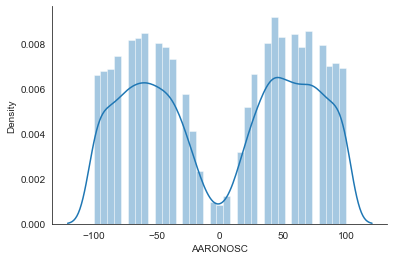

In [156]:
with sns.axes_style("white"):
    sns.distplot(data.AARONOSC)
    sns.despine()

### 能量平衡 (BOP)

能量平衡（BOP）旨在通过评估双方推动价格的能量来衡量市场上买方相对于卖方的实力。它是计算机上的收盘价和开盘价之间的差值除以最高价和最低价之间的差值：

$$
\text{BOP}_t= \frac{P_t^\text{Close}-P_t^\text{Open}}{P_t^\text{High}-P_t^\text{Low}}
$$

In [157]:
df = price_sample.loc['2022', ['open', 'high', 'low', 'close']]

In [158]:
df['BOP'] = talib.BOP(open=df.open,
                      high=df.high,
                      low=df.low,
                      close=df.close)

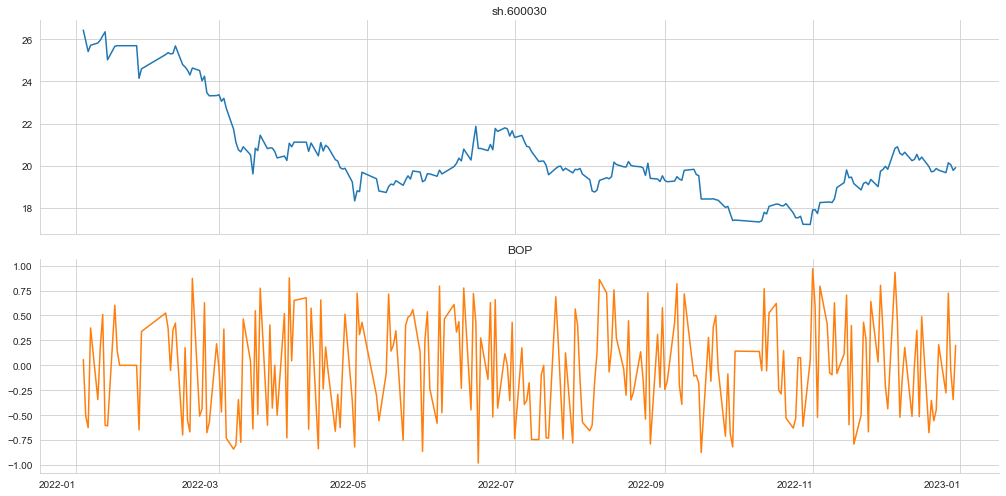

In [159]:
axes = df[['close', 'BOP']].plot(figsize=(14, 7), rot=0, subplots=True, title=['sh.600030', 'BOP'], legend=False)
axes[1].set_xlabel('')
sns.despine()
plt.tight_layout();

In [160]:
by_ticker = data.groupby('code', group_keys=False)

In [161]:
data['BOP'] = (by_ticker
               .apply(lambda x: talib.BOP(x.open,
                                          x.high,
                                          x.low,
                                          x.close)))

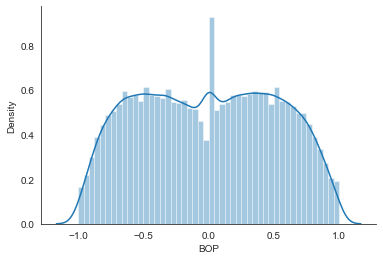

In [162]:
q = 0.0005
with sns.axes_style("white"):
    sns.distplot(data.BOP.clip(lower=data.BOP.quantile(q),
                               upper=data.BOP.quantile(1-q)))
    sns.despine()

### 商品通道指数 (CCI)

商品通道指数 (CCI) 衡量当前“典型”价格之间的差异，计算为当前最低价、最高价和收盘价与历史平均价的平均值。正（负）CCI 表明价格高于（低于）历史平均水平。当 CCI 低于零时，价格低于历史平均水平。其计算公式为：

$$
\begin{align*}
\bar{P_t}&=\frac{P_t^H+P_t^L+P_t^C}{3}\\
\text{CCI}_t & =\frac{\bar{P_t} - \text{SMA}(T)_t}{0.15\sum_{t=i}^T |\bar{P_t}-\text{SMA}(N)_t|/T}
\end{align*}
$$

In [163]:
df = price_sample.loc['2022', ['high', 'low', 'close']]

In [164]:
df['CCI'] = talib.CCI(high=df.high,
                      low=df.low,
                      close=df.close,
                      timeperiod=14)

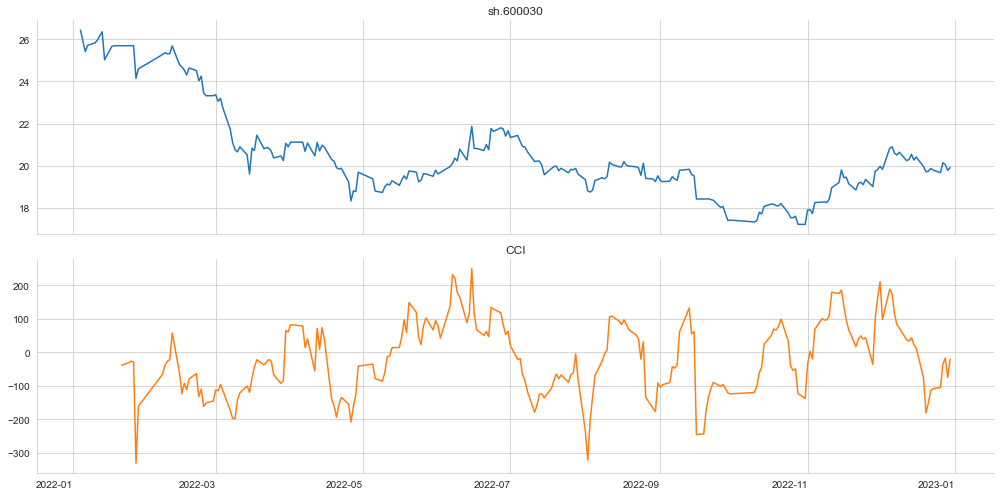

In [165]:
axes = df[['close', 'CCI']].plot(figsize=(14, 7), 
                                 rot=0, 
                                 subplots=True, 
                                 title=['sh.600030', 'CCI'], 
                                 legend=False)
axes[1].set_xlabel('')
sns.despine()
plt.tight_layout()

In [166]:
data['CCI'] = (by_ticker
               .apply(lambda x: talib.CCI(x.high,
                                          x.low,
                                          x.close,
                                          timeperiod=14)))

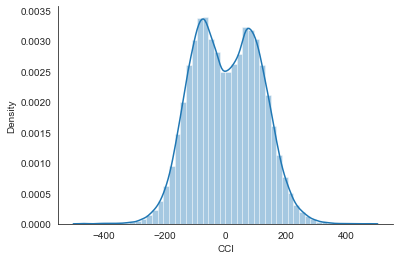

In [167]:
with sns.axes_style('white'):
    sns.distplot(data.CCI)
    sns.despine();

### 平滑异同移动平均线 (MACD)

移动平均收敛散度 (MACD) 是一种趋势跟踪（滞后）动量指标，显示证券价格的两条移动平均线之间的关系。它的计算方法是从 12 周期 EMA 减去 26 周期指数移动平均线 (EMA)。

TA-Lib 实现返回 MACD 值及其信号线，即 MACD 的 9 日 EMA。此外，MACD 柱状图测量指标与其信号线之间的距离。

In [181]:
df = price_sample.loc['2022', ['close']]

In [182]:
macd, macdsignal, macdhist = talib.MACD(df.close,
                                        fastperiod=12,
                                        slowperiod=26,
                                        signalperiod=9)
df['MACD'] = macd
df['MACDSIG'] = macdsignal
df['MACDHIST'] = macdhist

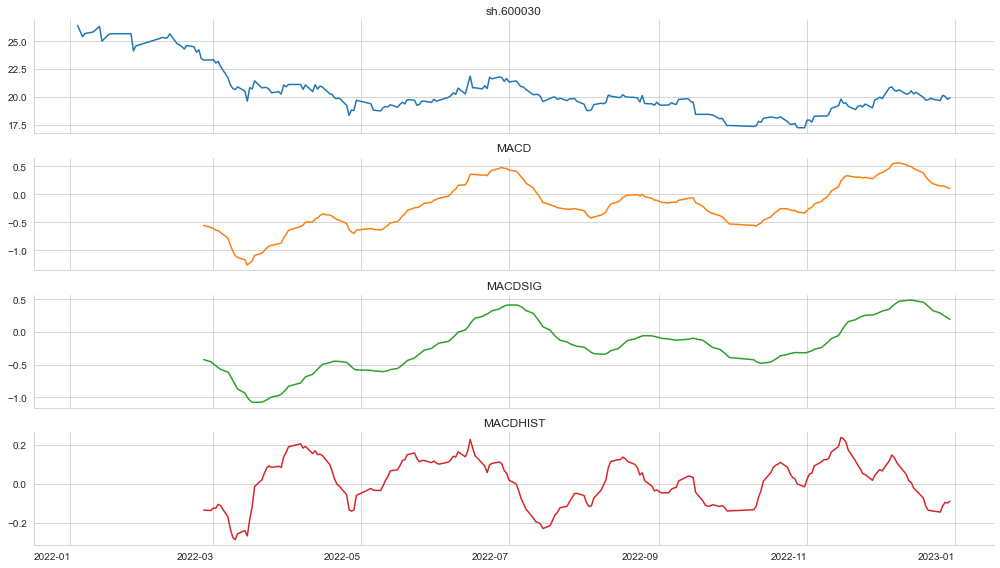

In [183]:
axes = df.plot(figsize=(14, 8),
               rot=0,
               subplots=True,
               title=['sh.600030', 'MACD', 'MACDSIG', 'MACDHIST'],
               legend=False)

axes[-1].set_xlabel('')
sns.despine()
plt.tight_layout()

In [176]:
def compute_macd(close, fastperiod=12, slowperiod=26, signalperiod=9):
    macd, macdsignal, macdhist = talib.MACD(close,
                                            fastperiod=fastperiod,
                                            slowperiod=slowperiod,
                                            signalperiod=signalperiod)
    return pd.DataFrame({'MACD': macd,
                         'MACD_SIGNAL': macdsignal,
                         'MACD_HIST': macdhist},
                        index=close.index)

In [184]:
data = (data.join(data
                  .groupby(level='code')
                  .close
                  .apply(compute_macd)))

ValueError: columns overlap but no suffix specified: Index(['MACD', 'MACD_SIGNAL', 'MACD_HIST'], dtype='object')

In [178]:
macd_indicators = ['MACD', 'MACD_SIGNAL', 'MACD_HIST']

In [179]:
data[macd_indicators].corr()

,MACD,MACD_SIGNAL,MACD_HIST
MACD,1.000000,0.951906,0.344975
MACD_SIGNAL,0.951906,1.000000,0.040802
MACD_HIST,0.344975,0.040802,1.000000


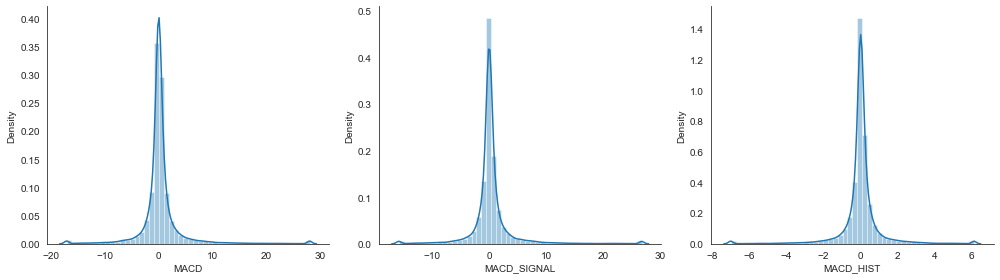

In [180]:
q = .005
with sns.axes_style('white'):
    fig, axes = plt.subplots(ncols=3, figsize=(14, 4))
    df_ = data[macd_indicators]
    df_ = df_.clip(df_.quantile(q), 
                   df_.quantile(1-q), axis=1)
    for i, indicator in enumerate(macd_indicators):
        sns.distplot(df_[indicator], ax=axes[i])
    sns.despine()
    fig.tight_layout();

### Chande 动量振荡器 (CMO)

Chande 动量振荡器 (CMO) 旨在衡量上涨和下跌日的动量。它的计算方式为时间段 T 内收益和损失之和的差额除以同一时期内所有价格变动的总和。它在+100 和-100 之间振荡。


In [120]:
df = price_sample.loc['2023', ['close']]

In [121]:
df['CMO'] = talib.CMO(df.close, timeperiod=14)

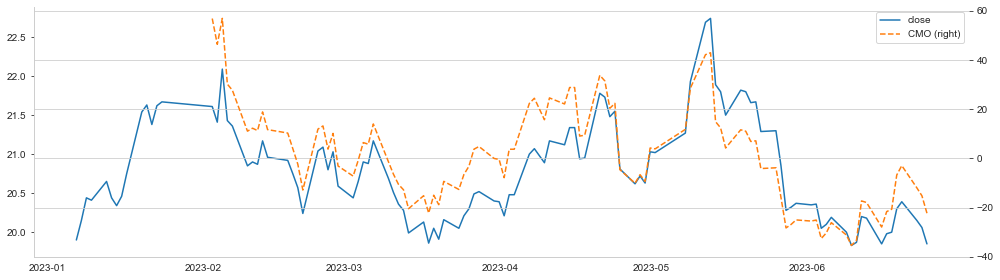

In [122]:
ax = df.plot(figsize=(14, 4), rot=0, secondary_y=['CMO'], style=['-', '--'])

ax.set_xlabel('')
sns.despine()
plt.tight_layout()

由于与 PPO 高度相关，PPO 未包括在内。

In [111]:
# data['CMO'] = (by_ticker
#                .apply(lambda x: talib.CMO(x.close,
#                                           timeperiod=14)))

In [112]:
# sns.distplot(data.CMO);

### 资金流向指数

资金流量指数 (MFI) 结合价格和交易量信息来识别超买或超卖状况。该指标通常使用 14 个周期的数据计算。 MFI 读数高于 80 被视为超买，MFI 读数低于 20 被视为超卖。


In [144]:
df = price_sample.loc['2022', ['high', 'low', 'close', 'volume']]

In [145]:
df['MFI'] = talib.MFI(df.high, 
                      df.low, 
                      df.close, 
                      df.volume, 
                      timeperiod=14)

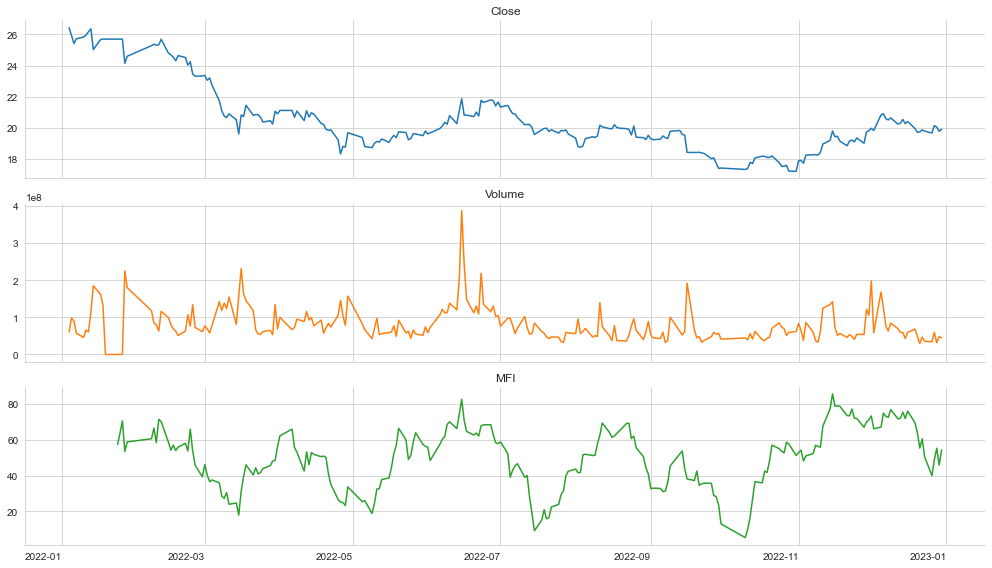

In [146]:
axes = df[['close', 'volume', 'MFI']].plot(figsize=(14, 8),
                                           rot=0,
                                           subplots=True,
                                           title=['Close', 'Volume', 'MFI'],
                                           legend=False)
axes[-1].set_xlabel('')
sns.despine()
plt.tight_layout()

In [147]:
data['MFI'] = (by_ticker
               .apply(lambda x: talib.MFI(x.high,
                                          x.low,
                                          x.close,
                                          x.volume,
                                          timeperiod=14)))

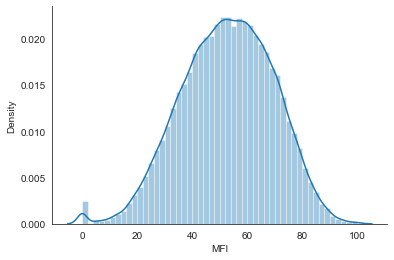

In [148]:
with sns.axes_style('white'):
    sns.distplot(data.MFI)
    sns.despine()

### 相对强度指数

RSI 比较股票近期价格变化的幅度，以确定股票是否超买或超卖。高 RSI（通常高于 70）表明超买，低 RSI（通常低于 30）表明超卖。它首先计算给定数量（通常是 14 个）先前交易日的价格上涨和下跌的平均价格变化，分别为 $\text{up}_t$ 和 $\text{down}_t$。然后，RSI 计算如下：

$$
\text{RSI}_t=100-\frac{100}{1+\frac{\text{up}_t}{\text{down}_t}}
$$



In [139]:
df = price_sample.loc['2022', ['close']]

In [140]:
df['RSI'] = talib.RSI(df.close, timeperiod=14)

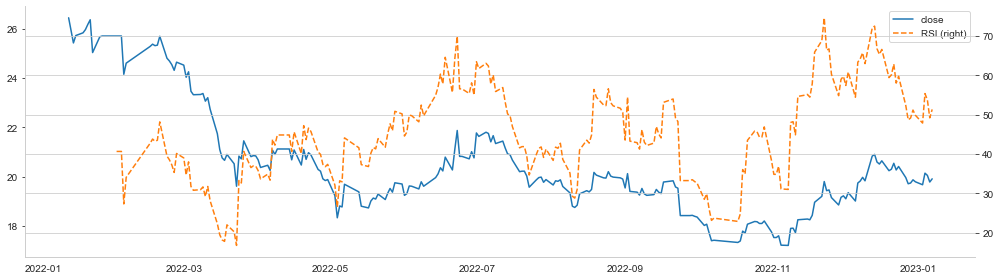

In [141]:
ax = df.plot(figsize=(14, 4), rot=0, secondary_y=['RSI'], style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

In [142]:
data['RSI'] = (by_ticker
               .apply(lambda x: talib.RSI(x.close,
                                          timeperiod=14)))

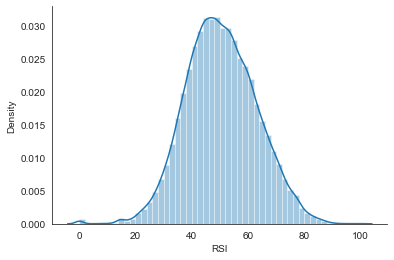

In [143]:
with sns.axes_style('white'):
    sns.distplot(data.RSI)
    sns.despine();

#### 随机 RSI (STOCHRSI)

随机相对强度指数 (STOCHRSI) 基于刚刚描述的 RSI，旨在识别交叉以及超买和超卖情况。它将当前 RSI 与给定时间段 T 内最低 RSI 的距离与 RSI 在该时间段内假定的最大值范围进行比较。其计算方法如下：

$$
\text{STOCHRSI}_t= \frac{\text{RSI}_t-\text{RSI}_t^L(T)}{\text{RSI}_t^H(T)-\text{RSI}_t^L(T)}
$$

TA-Lib 实现比 Chande 和 Kroll (1993) 最初的“非平滑随机 RSI”版本提供了更大的灵活性。要计算原始指标，请保持“timeperiod”和“fastk_period”相等。

返回值“fastk”是未平滑的 RSI。 `fastd_period` 用于计算平滑的 STOCHRSI，其返回为 `fastd`。如果您不关心 STOCHRSI 平滑，只需将“fastd_period”设置为 1 并忽略“fastd”输出。

参考：Tushar Chande 和 Stanley Kroll 的《随机 RSI 和动态动量指数》 Stock&Commodities V.11:5 (189-199)


In [136]:
df = price_sample.loc['2022', ['close']]

In [137]:
fastk, fastd = talib.STOCHRSI(df.close,
                              timeperiod=14, 
                              fastk_period=14, 
                              fastd_period=3, 
                              fastd_matype=0)
df['fastk'] = fastk
df['fastd'] = fastd

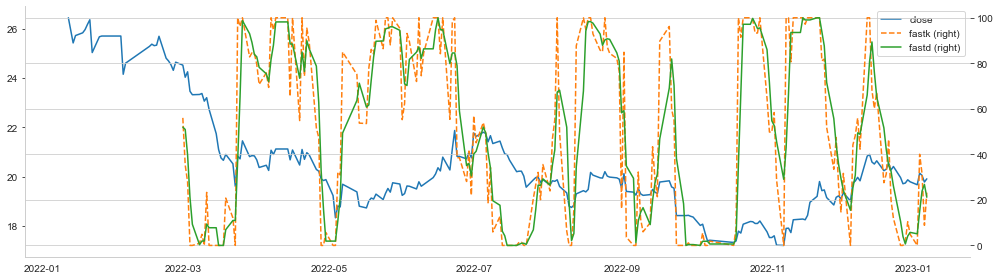

In [138]:
ax = df.plot(figsize=(14, 4),
             rot=0,
             secondary_y=['fastk', 'fastd'], style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

In [126]:
data['STOCHRSI'] = (by_ticker.apply(lambda x: talib.STOCHRSI(x.close,
                                                             timeperiod=14,
                                                             fastk_period=14,
                                                             fastd_period=3,
                                                             fastd_matype=0)[0]))

### 随机指标 (STOCH)

随机振荡指标是一种动量指标，将证券的特定收盘价与其在一定时期内的一系列价格进行比较。随机振荡指标基于收盘价应确认趋势的理念。


对于随机指标 (STOCH)，有四种不同的线：“FASTK”、“FASTD”、“SLOWK”和“SLOWD”。 “D”是通常在其相应的“K”功能上绘制的信号线。

$$
\begin{align*}
& K^\text{Fast}(T_K) & = &\frac{P_t-P_{T_K}^L}{P_{T_K}^H-P_{T_K}^L}* 100 \\
& D^\text{Fast}(T_{\text{FastD}}) & = & \text{MA}(T_{\text{FastD}})[K^\text{Fast}]\\
& K^\text{Slow}(T_{\text{SlowK}}) & = &\text{MA}(T_{\text{SlowK}})[K^\text{Fast}]\\
& D^\text{Slow}(T_{\text{SlowD}}) & = &\text{MA}(T_{\text{SlowD}})[K^\text{Slow}]
\end{align*}
$$

$P_{T_K}^L$、$P_{T_K}^H$ 和 $P_{T_K}^L$ 是最后一个 $T_K$ 期间的极值。
 使用相同周期时，$K^\text{Slow}$ 和 $D^\text{Fast}$ 是等效的。

In [186]:
df = price_sample.loc['2022', ['high', 'low', 'close']]

In [187]:
slowk, slowd = talib.STOCH(df.high,
                           df.low,
                           df.close,
                           fastk_period=14,
                           slowk_period=3,
                           slowk_matype=0,
                           slowd_period=3,
                           slowd_matype=0)
df['STOCH'] = slowd / slowk

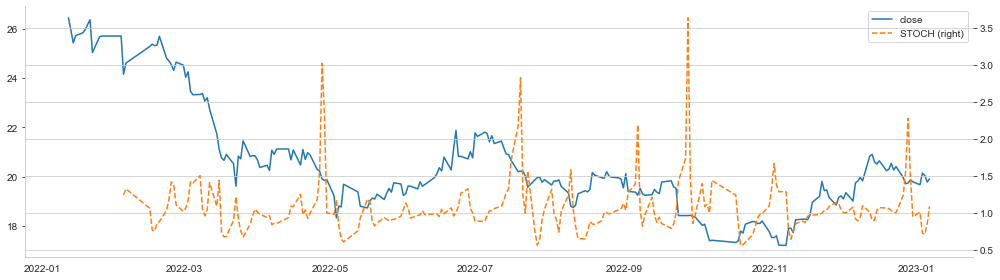

In [188]:
ax = df[['close', 'STOCH']].plot(figsize=(14, 4),
                                 rot=0,
                                 secondary_y='STOCH', style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

In [189]:
def compute_stoch(x, fastk_period=14, slowk_period=3, 
                  slowk_matype=0, slowd_period=3, slowd_matype=0):
    slowk, slowd = talib.STOCH(x.high, x.low, x.close,
                           fastk_period=fastk_period,
                           slowk_period=slowk_period,
                           slowk_matype=slowk_matype,
                           slowd_period=slowd_period,
                           slowd_matype=slowd_matype)
    return slowd/slowk-1

In [190]:
data['STOCH'] = by_ticker.apply(compute_stoch)
data.loc[data.STOCH.abs() > 1e5, 'STOCH'] = np.nan

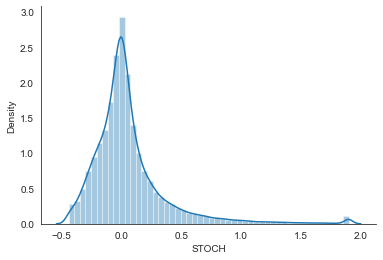

In [191]:
q = 0.005
with sns.axes_style('white'):
    sns.distplot(data.STOCH.clip(lower=data.STOCH.quantile(q),
                             upper=data.STOCH.quantile(1-q)));

    sns.despine();

### 终极振荡器 (ULTOSC)

由 Larry Williams 开发的终极震荡指标 (ULTOSC) 衡量三个时间范围内当前收盘价与前一个最低价格的平均差值（默认值：7、14 和 28），以避免对短期价格变化反应过度，并将短期、中期和长期的市场趋势。它首先计算购买压力 $\text{BP}_t$，然后将其在三个时期 $T_1、T_2、T_3$ 上求和，并按真实波幅 ​​($\text{TR}_t$ 标准化)。
$$
\begin{align*}
\text{BP}_t & = P_t^\text{Close}-\min(P_{t-1}^\text{Close}, P_t^\text{Low})\\ 
\text{TR}_t & = \max(P_{t-1}^\text{Close}, P_t^\text{High})-\min(P_{t-1}^\text{Close}, P_t^\text{Low})
\end{align*}
$$

然后将 ULTOSC 计算为三个时期的加权平均值，如下所示：
$$
\begin{align*}
\text{Avg}_t(T) & = \frac{\sum_{i=0}^{T-1} \text{BP}_{t-i}}{\sum_{i=0}^{T-1} \text{TR}_{t-i}}\\
\text{ULTOSC}_t & = 100*\frac{4\text{Avg}_t(7) + 2\text{Avg}_t(14) + \text{Avg}_t(28)}{4+2+1}
\end{align*}
$$

In [192]:
df = price_sample.loc['2022', ['high', 'low', 'close']]

In [193]:
df['ULTOSC'] = talib.ULTOSC(df.high,
                            df.low,
                            df.close,
                            timeperiod1=7,
                            timeperiod2=14,
                            timeperiod3=28)

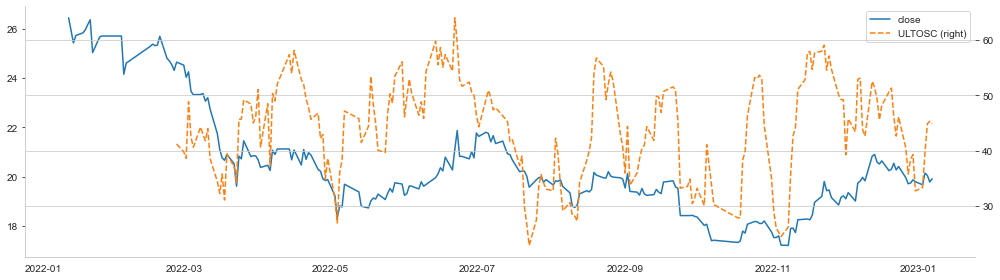

In [194]:
ax = df[['close', 'ULTOSC']].plot(figsize=(14, 4),
                                  rot=0,
                                  secondary_y='ULTOSC', style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

In [195]:
def compute_ultosc(x, timeperiod1=7, timeperiod2=14, timeperiod3=28):
    return talib.ULTOSC(x.high,
                        x.low,
                        x.close,
                        timeperiod1=timeperiod1,
                        timeperiod2=timeperiod2,
                        timeperiod3=timeperiod3)

In [196]:
data['ULTOSC'] = by_ticker.apply(compute_ultosc)

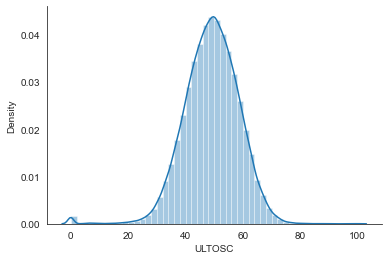

In [197]:
with sns.axes_style('white'):
    sns.distplot(data.ULTOSC)
    sns.despine();

### Williams' %R (WILLR)

威廉姆斯 %R，也称为威廉姆斯百分比范围，是一个动量指标，在 0 到 -100 之间移动，衡量超买和超卖水平以确定进入和退出点。它与随机震荡指标类似，将当前收盘价 $P_t^\text{Close}$ 与最高价 ($P_T^\text{High}$) 和最低价 ($P_T^\text{Low}$ 的范围进行比较) 过去 T 周期（通常为 14）的价格。指标计算如下：

$$
\text{WILLR}_t = \frac{P_T^\text{High}-P_t^\text{Close}}{P_T^\text{High}-P_T^\text{Low}}
$$


In [198]:
df = price_sample.loc['2022', ['high', 'low', 'close']]

In [199]:
df['WILLR'] = talib.WILLR(df.high,
                          df.low,
                          df.close,
                          timeperiod=14)

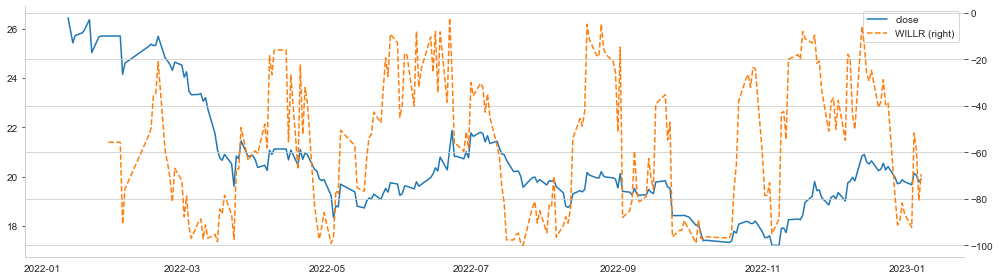

In [200]:
ax = df[['close', 'WILLR']].plot(figsize=(14, 4),
                                 rot=0,
                                 secondary_y='WILLR', style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

In [201]:
data['WILLR'] = by_ticker.apply(lambda x: talib.WILLR(x.high, x.low, x.close, timeperiod=14))

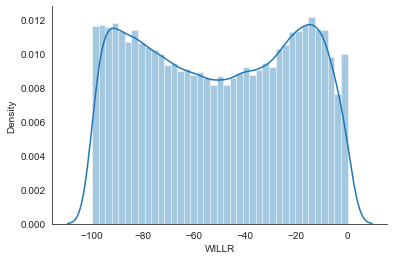

In [202]:
with sns.axes_style('white'):
    sns.distplot(data.WILLR)
    sns.despine();

## 成交量指标

|函数|             指标名称|
|:---|:---|
|AD|                   Chaikin A/D 线|
|ADOSC|                Chaikin A/D 振荡器|
|OBV|                  平衡成交量|

### Chaikin A/D 线

Chaikin 上涨/下跌或累积/分配线 (AD) 是一种基于交易量的指标，旨在衡量流入和流出资产的累计资金流量。该指标假设买入或卖出压力的程度可以通过收盘位置（相对于该期间的高点和低点）来确定。当股票收盘价位于一个周期区间的上半部分（下半部分）时，就会出现买入（卖出）压力。目的是当指标偏离证券价格时发出方向变化的信号。

累积/分配线是每个时期资金流量的运行总计。其计算方法如下：

1. 资金流量乘数（MFI）是接近高低范围的关系：
2. MFI 乘以该期间的交易量 $V_t$，得出资金流量 (MFV)。
3. 资金流量的累计形成累积分配线：
$$
\begin{align*}
&\text{MFI}_t&=\frac{P_t^\text{Close}-P_t^\text{Low}}{P_t^\text{High}-P_t^\text{Low}}\\
&\text{MFV}_t&=\text{MFI}_t \times V_t\\
&\text{AD}_t&=\text{AD}_{t-1}+\text{MFV}_t
\end{align*}
$$

In [203]:
df = price_sample.loc['2022', ['high', 'low', 'close', 'volume']]

In [204]:
df['AD'] = talib.AD(df.high,
                    df.low,
                    df.close,
                    df.volume)

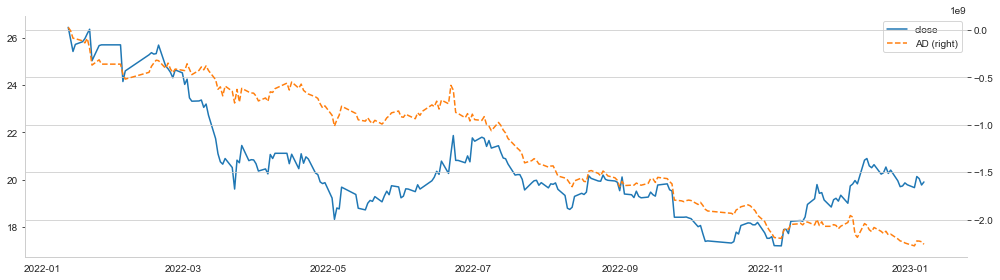

In [205]:
ax = df[['close', 'AD']].plot(figsize=(14, 4),
                              rot=0,
                              secondary_y='AD', style=['-', '--'])

ax.set_xlabel('')
sns.despine()
plt.tight_layout()

除以平均交易量以对资产进行标准化。

In [206]:
data['AD'] = by_ticker.apply(lambda x: talib.AD(x.high, x.low, x.close, x.volume)/x.volume.mean())

In [207]:
data.AD.replace((np.inf, -np.inf), np.nan).dropna().describe()

count    72550.000000
mean        11.183440
std         27.439428
min        -96.853974
25%         -1.291238
50%          7.856449
75%         25.199291
max        108.599166
Name: AD, dtype: float64

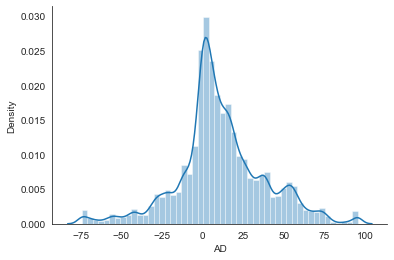

In [208]:
q = 0.005
AD = data.AD.replace((np.inf, -np.inf), np.nan).dropna()
with sns.axes_style('white'):
    sns.distplot(AD.clip(lower=AD.quantile(q),
                     upper=AD.quantile(1-q)));

    sns.despine();

### Chaikin A/D 振荡器 (ADOSC)

Chaikin A/D 振荡器 (ADOSC) 是应用于 Chaikin A/D 线的移动平均收敛分歧指标 (MACD)。柴金振荡器旨在预测累积/派发线的变化。

它的计算方式为累积/分布线的 3 日指数移动平均线与 10 日指数移动平均线之间的差值。

In [210]:
df = price_sample.loc['2022', ['high', 'low', 'close', 'volume']]

In [211]:
df['ADOSC'] = talib.ADOSC(df.high,
                          df.low,
                          df.close,
                          df.volume,
                          fastperiod=3,
                          slowperiod=10)

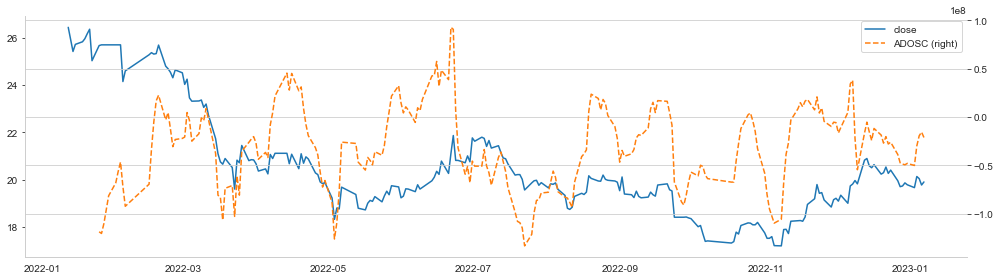

In [212]:
ax = df[['close', 'ADOSC']].plot(figsize=(14, 4),
                                 rot=0,
                                 secondary_y='ADOSC', style=['-', '--'])

ax.set_xlabel('')
sns.despine()
plt.tight_layout()

In [213]:
data['ADOSC'] = by_ticker.apply(lambda x: talib.ADOSC(x.high,
                                                      x.low,
                                                      x.close,
                                                      x.volume,
                                                      fastperiod=3,
                                                      slowperiod=10)/x.rolling(14).volume.mean())

OverflowError: cannot convert float infinity to integer

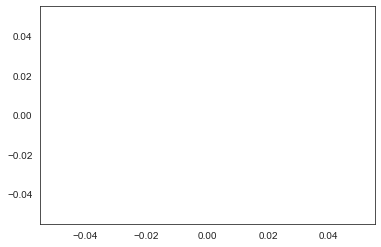

In [226]:
q = 0.0001
with sns.axes_style('white'):
    sns.distplot(data.ADOSC.clip(lower=data.ADOSC.quantile(q),
                             upper=data.ADOSC.quantile(1-q)))
    sns.despine()

### 平衡交易量 (OBV)

平衡成交量指标 (OBV) 是一种将成交量与价格变化联系起来的累积动量指标。它假设 OBV 变化先于价格变化，因为可以看到智能资金随着 OBV 的上升而流入证券。当公众随后进入安全性时，安全性和OBV都会上升。

如果证券收盘价高于（低于）前一收盘价，则当前 OBV 的计算方法是将当前交易量与最后一个 OBV 相加（减去）。

$$
\text{OBV}_t = 
\begin{cases}
\text{OBV}_{t-1}+V_t & \text{if }P_t>P_{t-1}\\
\text{OBV}_{t-1}-V_t & \text{if }P_t<P_{t-1}\\
\text{OBV}_{t-1} & \text{otherwise}
\end{cases}
$$

In [219]:
df = price_sample.loc['2022', ['close', 'volume']]

In [220]:
df['OBV'] = talib.OBV(df.close,
                      df.volume)

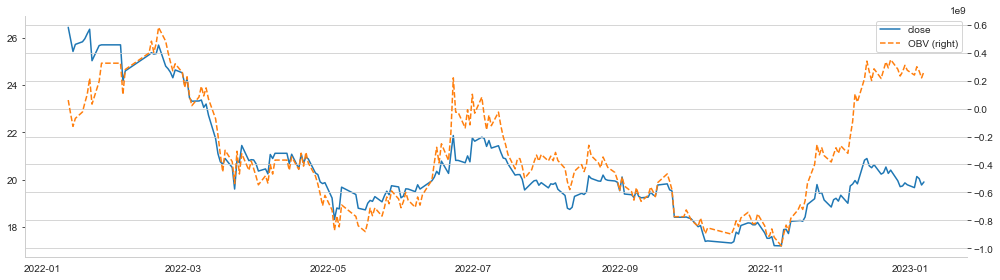

In [221]:
ax = df[['close', 'OBV']].plot(figsize=(14, 4),
                               rot=0,
                               secondary_y='OBV', style=['-', '--'])
ax.set_xlabel('')
sns.despine()
plt.tight_layout()

In [222]:
data['OBV'] = by_ticker.apply(lambda x: talib.OBV(x.close,
                                                  x.volume)/x.expanding().volume.mean())

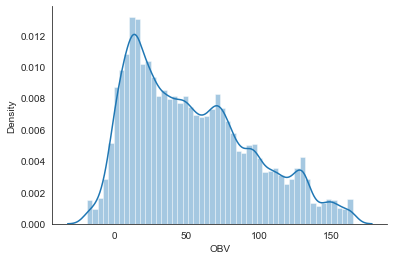

In [223]:
q = 0.0025
with sns.axes_style('white'):
    sns.distplot(data.OBV.clip(lower=data.OBV.quantile(q),
                               upper=data.OBV.quantile(1-q)))
    sns.despine()

## 波动率指标

|函数|             名称|
|:---|:---|
|TRANGE|               真实波幅|
|ATR|                  平均真实波幅|
|NATR|                 归一化平均真实波动范围|

### ATR

平均真实波动幅度指标（ATR）显示市场的波动性。它由 Welles Wilder (1978) 提出，此后一直被用作许多其他指标的组成部分。它的目的是预测趋势的变化，其值越高，趋势变化的概率就越高；指标值越低，当前趋势越弱。

它被计算为真实波动范围 (TRANGE) 的 T 周期内的简单移动平均线，以最近最大交易范围的绝对值来衡量波动性：
$$
\text{TRANGE}_t = \max\left[P_t^\text{High} - P_t^\text{low}, \left| P_t^\text{High} - P_{t-1}^\text{Close}\right|, \left| P_t^\text{low} - P_{t-1}^\text{Close}\right|\right]
$$

In [224]:
df = price_sample.loc['2022', ['high', 'low', 'close']]

In [225]:
df['ATR'] = talib.ATR(df.high,
                      df.low,
                      df.close,
                      timeperiod=14)

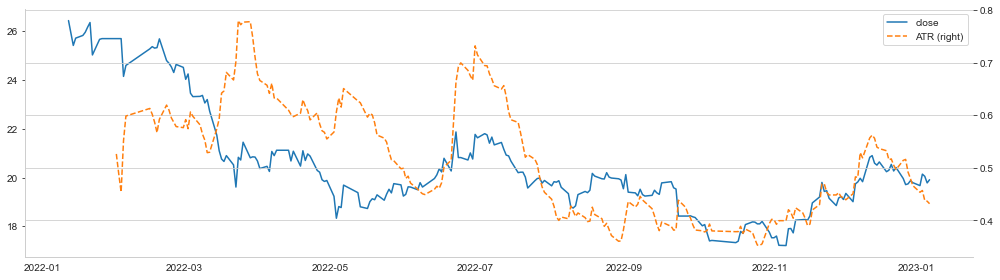

In [227]:
ax = df[['close', 'ATR']].plot(figsize=(14, 4),
                          rot=0,
                          secondary_y='ATR', style=['-', '--'])

ax.set_xlabel('')
sns.despine()
plt.tight_layout()

#### 使用价格滚动平均值计算 ATR 的标准化版本

In [228]:
data['ATR'] = by_ticker.apply(lambda x: talib.ATR(x.high,
                                                  x.low,
                                                  x.close,
                                                  timeperiod=14)/x.rolling(14).close.mean())

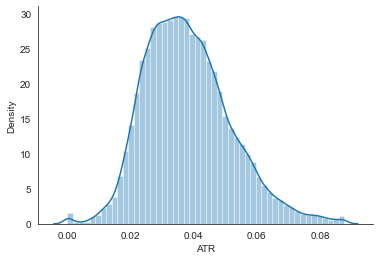

In [229]:
q = 0.001
with sns.axes_style('white'):
    sns.distplot(data.ATR.clip(upper=data.ATR.quantile(1-q)))
    sns.despine()

### NATR

归一化平均真实波幅 ​​(NATR) 是 ATR 的归一化版本，计算公式如下：

$$
\text{NATR}_t = \frac{\text{ATR}_t(T)}{P_t^\text{Close}} * 100
$$

归一化使 ATR 函数在以下场景中更加相关：
- 价格剧烈变化的长期分析。
- 跨市场或跨证券 ATR 比较。

In [230]:
df = price_sample.loc['2022', ['high', 'low', 'close']]

In [231]:
df['NATR'] = talib.NATR(df.high,
                        df.low,
                        df.close,
                        timeperiod=14)

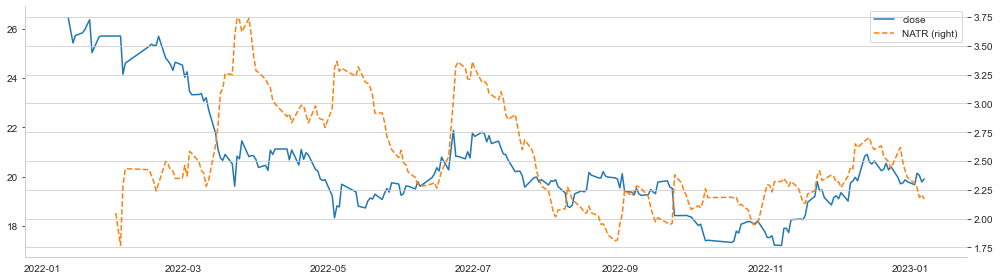

In [232]:
ax = df[['close', 'NATR']].plot(figsize=(14, 4),
                           rot=0,
                           secondary_y='NATR', style=['-', '--'])

ax.set_xlabel('')
sns.despine()
plt.tight_layout()

由于与 ATR 高度相关，未包含在数据中。

In [168]:
# data['NATR'] = by_ticker.apply(lambda x: talib.NATR(x.high,
#                                                     x.low,
#                                                     x.close,
#                                                     timeperiod=14))

In [169]:
# q = 0.001
# sns.distplot(data.NATR.clip(upper=data.NATR.quantile(1-q)));

## 滚动因子贝塔值

In [238]:
factor_data = (web.DataReader('F-F_Research_Data_5_Factors_2x3_daily', 'famafrench', 
                              start=2020)[0].rename(columns={'Mkt-RF': 'MARKET'}))
factor_data.index.names = ['date']

In [239]:
factors = factor_data.columns[:-1]
factors

Index(['MARKET', 'SMB', 'HML', 'RMW', 'CMA'], dtype='object')

In [240]:
factor_data.head()

,MARKET,SMB,HML,RMW,CMA,RF
date,,,,,,
2020-01-02,0.86,-0.97,-0.34,0.24,-0.22,0.006
2020-01-03,-0.67,0.30,0.01,-0.14,-0.10,0.006
2020-01-06,0.36,-0.21,-0.55,-0.17,-0.26,0.006
2020-01-07,-0.19,-0.03,-0.25,-0.13,-0.25,0.006
2020-01-08,0.47,-0.17,-0.64,-0.20,-0.17,0.006


In [241]:
t = 1
ret = f'ret_{t:02}'

windows = [21, 63, 252]
for window in windows:
    print(window)
    betas = []
    for ticker, df in data.groupby('code', group_keys=False):
        model_data = df[[ret]].merge(factor_data, on='date').dropna()
        model_data[ret] -= model_data.RF

        rolling_ols = RollingOLS(endog=model_data[ret], 
                                 exog=sm.add_constant(model_data[factors]), window=window)
        factor_model = rolling_ols.fit(params_only=True).params.rename(columns={'const':'ALPHA'})
        result = factor_model.assign(ticker=ticker).set_index('code', append=True).swaplevel()
        betas.append(result)
    betas = pd.concat(betas).rename(columns=lambda x: f'{x}_{window:02}')
    data = data.join(betas)

21


## 尺寸代理

In [173]:
data['size_factor'] = by_ticker.close.apply(lambda x: x.fillna(method='bfill').div(x.iloc[0]))

In [174]:
data['size_proxy'] = data.marketcap.mul(data.size_factor).div(1e6)

## 保留结果

In [175]:
data = (data
        .drop(['open', 'high', 'low', 'close', 'volume', 'marketcap'], axis=1)
        .replace((np.inf, -np.inf), np.nan))

In [176]:
data.dropna(how='all').info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1255093 entries, ('A', Timestamp('2007-01-04 00:00:00')) to ('ZION', Timestamp('2016-12-29 00:00:00'))
Data columns (total 57 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   sector       1255093 non-null  float64
 1   ret_01       1254593 non-null  float64
 2   ret_02       1254093 non-null  float64
 3   ret_03       1253593 non-null  float64
 4   ret_04       1253093 non-null  float64
 5   ret_05       1252593 non-null  float64
 6   ret_10       1250093 non-null  float64
 7   ret_21       1244593 non-null  float64
 8   ret_42       1234093 non-null  float64
 9   ret_63       1223593 non-null  float64
 10  ret_126      1192093 non-null  float64
 11  ret_252      1129093 non-null  float64
 12  ret_fwd      1255093 non-null  float64
 13  BB_UP        1245593 non-null  float64
 14  BB_LOW       1245593 non-null  float64
 15  BB_SQUEEZE   1245593 non-null  float64
 16  HT           1223

In [177]:
with pd.HDFStore('data.h5') as store:
    store.put('factors/common', data)